In [ ]:
from __future__ import print_function
import argparse
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [ ]:
# class netG(nn.Module):

#     def __init__(self, nz, ngf, nc):

#         super(netG, self).__init__()
#         self.ReLU = nn.ReLU(True)
#         self.Tanh = nn.Tanh()
#         self.DropOut = nn.Dropout(p=0.75)
#         #self.conv0 = nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 1, bias=False)
#         #self.BatchNorm0 = nn.BatchNorm2d(ngf * 16)
#         self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 5, 1, 0, bias=False)
#         self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

#         self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 2, 2, bias=False)
#         self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)

#         self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 5, 2, 2, bias=False)
#         self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)

#         self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 2, bias=False)
#         self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)

#         self.conv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

#         self.apply(weights_init)


#     def forward(self, input):
#         #x = self.conv0(input)
#         #x = self.BatchNorm0(x)
#         #x = self.ReLU(x)
#         x = self.conv1(input)
#         x = self.BatchNorm1(x)
#         x = self.ReLU(x)
#         #x = self.DropOut(x)

#         x = self.conv2(x)
#         x = self.BatchNorm2(x)
#         x = self.ReLU(x)
#         x = self.DropOut(x)

#         x = self.conv3(x)
#         x = self.BatchNorm3(x)
#         x = self.ReLU(x)
#         #x = self.DropOut(x)

#         x = self.conv4(x)
#         x = self.BatchNorm4(x)
#         x = self.ReLU(x)
#         #x = self.DropOut(x)

#         x = self.conv5(x)
#         output = self.Tanh(x)
#         return output

In [ ]:
class netG(nn.Module):

    def __init__(self, nz, ngf, nc):

        super(netG, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        #self.DropOut = nn.Dropout(p=0.75)
        #self.conv0 = nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 1, bias=False)
        #self.BatchNorm0 = nn.BatchNorm2d(ngf * 16)
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)

        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)

        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)

        self.conv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):
        #x = self.conv0(input)
        #x = self.BatchNorm0(x)
        #x = self.ReLU(x)
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv5(x)
        output = self.Tanh(x)
        return output

In [ ]:
class netD(nn.Module):

    def __init__(self, ndf, nc, nb_label):

        super(netD, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.DropOut1 = nn.Dropout(p=0.5)
        self.DropOut2 = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        #x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s,c

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data_dir = '4/3AHDbc50wauQLH_Uxb1lOAm9fH5_nZ8o_gvOQGzGEebKG_8SK7yvan4div2k' #Just to check
data_dir = 'dataset_3_classes'
batch_size = 32
# Number of training epochs
num_epochs = 100

#All images will be resized to this size using a transformer.
#image_size = 64
imageSize = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# No of labels
nb_label = 3

# Learning rate for optimizers
lr = 0.002
lr_d = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
# Input to generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #batch of 64
# Define Loss function
s_criterion = nn.BCELoss().to(device) #For synthesizing
c_criterion = nn.NLLLoss().to(device) #For classification

input = torch.FloatTensor(batch_size, 3, imageSize, imageSize).to(device)
noise = torch.FloatTensor(batch_size, nz, 1, 1).to(device)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1).to(device)
s_label = torch.FloatTensor(batch_size).to(device)
c_label = torch.LongTensor(batch_size).to(device)

input = Variable(input)
s_label = Variable(s_label)
c_label = Variable(c_label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)
fixed_noise_ = np.random.normal(0, 1, (batch_size, nz))
random_label = np.random.randint(0, nb_label, batch_size)
#print('fixed label:{}'.format(random_label))
random_onehot = np.zeros((batch_size, nb_label))
random_onehot[np.arange(batch_size), random_label] = 1
fixed_noise_[np.arange(batch_size), :nb_label] = random_onehot[np.arange(batch_size)]


fixed_noise_ = (torch.from_numpy(fixed_noise_))
fixed_noise_ = fixed_noise_.resize_(batch_size, nz, 1, 1)
fixed_noise.data.copy_(fixed_noise_)

tensor([[[[ 0.0000]],

         [[ 0.0000]],

         [[ 1.0000]],

         ...,

         [[-1.5206]],

         [[ 1.9563]],

         [[ 0.1167]]],


        [[[ 1.0000]],

         [[ 0.0000]],

         [[ 0.0000]],

         ...,

         [[ 0.3869]],

         [[ 0.1829]],

         [[-1.6462]]],


        [[[ 0.0000]],

         [[ 0.0000]],

         [[ 1.0000]],

         ...,

         [[ 0.7970]],

         [[ 1.6955]],

         [[-0.0406]]],


        ...,


        [[[ 1.0000]],

         [[ 0.0000]],

         [[ 0.0000]],

         ...,

         [[ 0.2673]],

         [[-1.0765]],

         [[ 0.6081]]],


        [[[ 1.0000]],

         [[ 0.0000]],

         [[ 0.0000]],

         ...,

         [[ 0.6802]],

         [[ 0.0801]],

         [[ 0.7133]]],


        [[[ 0.0000]],

         [[ 1.0000]],

         [[ 0.0000]],

         ...,

         [[ 0.6454]],

         [[-0.4559]],

         [[ 0.8818]]]], device='cuda:0')

In [ ]:
for func in [
    lambda: os.mkdir(os.path.join('.', 'augGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/model/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/plots/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/output_images/ACGAN'))]:  # create directories
  try:
    func()
  except Exception as error:
    print(error)
    continue

METRIC_FIELDS = [
    'train.D_x',
    'train.D_G_z1',
    'train.D_G_z2',
    'train.G_losses',
    'train.D_losses',
]
metrics = {field: list() for field in METRIC_FIELDS}

if nc==1:
    mu = (0.5)
    sigma = (0.5)
    transform = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((64,64)),
                                    #transforms.Scale(imageSize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
elif nc==3:
    mu = (0.5,0.5,0.5)
    sigma = (0.5,0.5,0.5)
    #Originally authors used just scaling
    transform = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                    transforms.Resize((64,64)),
                                    #transforms.Scale(imageSize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
else:
    print("Tranformation not defined for this option")
train_set = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)

generator = netG(nz, ngf, nc).to(device)
discriminator = netD(ndf, nc, nb_label).to(device)

# setup optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

[Errno 17] File exists: './augGAN'
[Errno 17] File exists: './augGAN/model/ACGAN'
[Errno 17] File exists: './augGAN/plots/ACGAN'
[Errno 17] File exists: './augGAN/output_images/ACGAN'


In [ ]:
print(generator)
print(discriminator)

from torchsummary import summary

summary(generator, (100, 1, 1))
summary(discriminator, (1, 64, 64))

netG(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
netD(
  (LeakyReLU): LeakyReLU(negative_slope=0.2, inplace=True)
  (DropOut1): 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
def test(predict, labels):
    correct = 0
    pred = predict.data.max(1)[1]
    correct = pred.eq(labels.data).cpu().sum()
    return correct, len(labels.data)

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(train_loader, 0)):
        ###########################
        # (1) Update D network
        ###########################
        # train with real
        discriminator.zero_grad()
        img, label = data
        batch_size = img.size(0)
        with torch.no_grad():
            input.resize_(img.size()).copy_(img)
            s_label.resize_(batch_size).fill_(real_label)
            c_label.resize_(batch_size).copy_(label)
        s_output, c_output = discriminator(input)
        s_errD_real = s_criterion(s_output, s_label)
        c_errD_real = c_criterion(c_output, c_label)
        errD_real = s_errD_real + c_errD_real
        errD_real.backward()
        D_x = s_output.data.mean()
        
        correct, length = test(c_output, c_label)

        # train with fake
        with torch.no_grad():
            noise.resize_(batch_size, nz, 1, 1)
            noise.normal_(0, 1)

        label = np.random.randint(0, nb_label, batch_size)
        noise_ = np.random.normal(0, 1, (batch_size, nz))
        label_onehot = np.zeros((batch_size, nb_label))
        label_onehot[np.arange(batch_size), label] = 1
        noise_[np.arange(batch_size), :nb_label] = label_onehot[np.arange(batch_size)]
        
        noise_ = (torch.from_numpy(noise_))
        noise_ = noise_.resize_(batch_size, nz, 1, 1)
        noise.data.copy_(noise_)

        c_label.data.resize_(batch_size).copy_(torch.from_numpy(label))

        fake = generator(noise)
        s_label.data.fill_(fake_label)
        s_output,c_output = discriminator(fake.detach())
        s_errD_fake = s_criterion(s_output, s_label)
        c_errD_fake = c_criterion(c_output, c_label)
        errD_fake = s_errD_fake + c_errD_fake

        errD_fake.backward()
        D_G_z1 = s_output.data.mean()
        errD = s_errD_real + s_errD_fake
        optimizerD.step()

        ###########################
        # (2) Update G network
        ###########################
        generator.zero_grad()
        s_label.data.fill_(real_label)  # fake labels are real for generator cost
        s_output,c_output = discriminator(fake)
        s_errG = s_criterion(s_output, s_label)
        c_errG = c_criterion(c_output, c_label)
        
        errG = s_errG + c_errG
        errG.backward()
        D_G_z2 = s_output.data.mean()
        optimizerG.step()
        metrics['train.G_losses'].append(errG.item())
        metrics['train.D_losses'].append(errD.item())

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f, Accuracy: %.4f / %.4f = %.4f'
              % (epoch, num_epochs, i, len(train_loader),
                 errD.data, errG.data, D_x, D_G_z1, D_G_z2,
                 correct, length, 100.* correct / length))
        if i % 100 == 0:
            vutils.save_image(img,
                    '%s/real_samples.png' % './augGAN/output_images/ACGAN', normalize=True)
            #fake = netG(fixed_cat)
            fake = generator(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % ('./augGAN/output_images/ACGAN', epoch), normalize=True)

    # do checkpointing
    #torch.save(generator.state_dict(), '%s/netG_epoch_%d.pth' % (os.path.join('.', 'augGAN/model/ACGAN'), epoch))
    #torch.save(discriminator.state_dict(), '%s/netD_epoch_%d.pth' % (os.path.join('.', 'augGAN/model/ACGAN'), epoch))

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[0/100][0/8] Loss_D: 1.5366 Loss_G: 0.5480 D(x): 0.4445 D(G(z)): 0.4285 / 0.4463, Accuracy: 15.0000 / 32.0000 = 46.8750


 25%|██▌       | 2/8 [00:36<01:51, 18.54s/it]

[0/100][1/8] Loss_D: 1.2114 Loss_G: 1.8489 D(x): 0.8523 D(G(z)): 0.6131 / 0.1376, Accuracy: 7.0000 / 32.0000 = 21.8750


 38%|███▊      | 3/8 [00:54<01:31, 18.29s/it]

[0/100][2/8] Loss_D: 0.6635 Loss_G: 2.5500 D(x): 0.8345 D(G(z)): 0.3501 / 0.0722, Accuracy: 9.0000 / 32.0000 = 28.1250


 50%|█████     | 4/8 [01:10<01:11, 17.81s/it]

[0/100][3/8] Loss_D: 0.7254 Loss_G: 2.2284 D(x): 0.6931 D(G(z)): 0.2380 / 0.1007, Accuracy: 12.0000 / 32.0000 = 37.5000


 62%|██████▎   | 5/8 [01:28<00:53, 17.75s/it]

[0/100][4/8] Loss_D: 0.8938 Loss_G: 2.4968 D(x): 0.7710 D(G(z)): 0.3719 / 0.0743, Accuracy: 12.0000 / 32.0000 = 37.5000


 75%|███████▌  | 6/8 [01:46<00:35, 17.68s/it]

[0/100][5/8] Loss_D: 0.6395 Loss_G: 3.2994 D(x): 0.8588 D(G(z)): 0.3418 / 0.0386, Accuracy: 7.0000 / 32.0000 = 21.8750


 88%|████████▊ | 7/8 [02:07<00:18, 18.91s/it]

[0/100][6/8] Loss_D: 0.7416 Loss_G: 3.1950 D(x): 0.7587 D(G(z)): 0.2450 / 0.0383, Accuracy: 8.0000 / 32.0000 = 25.0000


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
  0%|          | 0/8 [00:00<?, ?it/s]

[0/100][7/8] Loss_D: 1.0464 Loss_G: 2.8487 D(x): 0.7016 D(G(z)): 0.4122 / 0.0610, Accuracy: 8.0000 / 23.0000 = 34.7826
[1/100][0/8] Loss_D: 0.6512 Loss_G: 3.3506 D(x): 0.7796 D(G(z)): 0.2662 / 0.0409, Accuracy: 10.0000 / 32.0000 = 31.2500


 25%|██▌       | 2/8 [00:03<00:09,  1.66s/it]

[1/100][1/8] Loss_D: 0.7474 Loss_G: 2.5412 D(x): 0.6867 D(G(z)): 0.1912 / 0.1078, Accuracy: 5.0000 / 32.0000 = 15.6250


 38%|███▊      | 3/8 [00:03<00:07,  1.43s/it]

[1/100][2/8] Loss_D: 1.5656 Loss_G: 4.0186 D(x): 0.7518 D(G(z)): 0.6019 / 0.0316, Accuracy: 13.0000 / 32.0000 = 40.6250


 50%|█████     | 4/8 [00:04<00:05,  1.33s/it]

[1/100][3/8] Loss_D: 1.9877 Loss_G: 2.9263 D(x): 0.3422 D(G(z)): 0.3556 / 0.1146, Accuracy: 11.0000 / 32.0000 = 34.3750


 62%|██████▎   | 5/8 [00:06<00:03,  1.25s/it]

[1/100][4/8] Loss_D: 2.4933 Loss_G: 2.4060 D(x): 0.5042 D(G(z)): 0.6039 / 0.1177, Accuracy: 11.0000 / 32.0000 = 34.3750


 75%|███████▌  | 6/8 [00:07<00:02,  1.20s/it]

[1/100][5/8] Loss_D: 2.4712 Loss_G: 1.6016 D(x): 0.3029 D(G(z)): 0.4390 / 0.1871, Accuracy: 13.0000 / 32.0000 = 40.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.20s/it]

[1/100][6/8] Loss_D: 1.6455 Loss_G: 1.4310 D(x): 0.4925 D(G(z)): 0.4227 / 0.2394, Accuracy: 11.0000 / 32.0000 = 34.3750


  0%|          | 0/8 [00:00<?, ?it/s]

[1/100][7/8] Loss_D: 1.3819 Loss_G: 2.5260 D(x): 0.6872 D(G(z)): 0.5199 / 0.0909, Accuracy: 5.0000 / 23.0000 = 21.7391
[2/100][0/8] Loss_D: 1.5268 Loss_G: 1.6094 D(x): 0.4756 D(G(z)): 0.3320 / 0.1765, Accuracy: 10.0000 / 32.0000 = 31.2500


 25%|██▌       | 2/8 [00:03<00:11,  1.84s/it]

[2/100][1/8] Loss_D: 1.6167 Loss_G: 1.7250 D(x): 0.5551 D(G(z)): 0.4677 / 0.1560, Accuracy: 12.0000 / 32.0000 = 37.5000


 38%|███▊      | 3/8 [00:04<00:07,  1.54s/it]

[2/100][2/8] Loss_D: 1.5708 Loss_G: 2.0736 D(x): 0.5563 D(G(z)): 0.4554 / 0.1206, Accuracy: 17.0000 / 32.0000 = 53.1250


 50%|█████     | 4/8 [00:05<00:05,  1.39s/it]

[2/100][3/8] Loss_D: 1.5663 Loss_G: 2.7578 D(x): 0.6007 D(G(z)): 0.5146 / 0.0731, Accuracy: 12.0000 / 32.0000 = 37.5000


 62%|██████▎   | 5/8 [00:06<00:03,  1.25s/it]

[2/100][4/8] Loss_D: 1.7811 Loss_G: 1.4719 D(x): 0.4769 D(G(z)): 0.4346 / 0.2205, Accuracy: 11.0000 / 32.0000 = 34.3750


 75%|███████▌  | 6/8 [00:06<00:02,  1.13s/it]

[2/100][5/8] Loss_D: 2.4151 Loss_G: 3.3080 D(x): 0.5217 D(G(z)): 0.7207 / 0.0431, Accuracy: 11.0000 / 32.0000 = 34.3750


 88%|████████▊ | 7/8 [00:07<00:01,  1.11s/it]

[2/100][6/8] Loss_D: 2.4459 Loss_G: 0.7890 D(x): 0.2005 D(G(z)): 0.3110 / 0.3740, Accuracy: 11.0000 / 32.0000 = 34.3750


  0%|          | 0/8 [00:00<?, ?it/s]

[2/100][7/8] Loss_D: 2.0180 Loss_G: 1.4142 D(x): 0.5913 D(G(z)): 0.6760 / 0.2412, Accuracy: 8.0000 / 23.0000 = 34.7826
[3/100][0/8] Loss_D: 1.8285 Loss_G: 2.9230 D(x): 0.5389 D(G(z)): 0.5739 / 0.0485, Accuracy: 11.0000 / 32.0000 = 34.3750


 25%|██▌       | 2/8 [00:02<00:09,  1.64s/it]

[3/100][1/8] Loss_D: 1.5001 Loss_G: 0.9874 D(x): 0.4060 D(G(z)): 0.3113 / 0.3114, Accuracy: 13.0000 / 32.0000 = 40.6250


 38%|███▊      | 3/8 [00:03<00:07,  1.42s/it]

[3/100][2/8] Loss_D: 2.3200 Loss_G: 2.5973 D(x): 0.6705 D(G(z)): 0.7942 / 0.0742, Accuracy: 9.0000 / 32.0000 = 28.1250


 50%|█████     | 4/8 [00:04<00:05,  1.35s/it]

[3/100][3/8] Loss_D: 2.4898 Loss_G: 1.4443 D(x): 0.2969 D(G(z)): 0.5242 / 0.1964, Accuracy: 12.0000 / 32.0000 = 37.5000


 62%|██████▎   | 5/8 [00:06<00:04,  1.35s/it]

[3/100][4/8] Loss_D: 2.2403 Loss_G: 1.0649 D(x): 0.3408 D(G(z)): 0.5269 / 0.2904, Accuracy: 8.0000 / 32.0000 = 25.0000


 75%|███████▌  | 6/8 [00:07<00:02,  1.17s/it]

[3/100][5/8] Loss_D: 2.3946 Loss_G: 1.8723 D(x): 0.5036 D(G(z)): 0.7403 / 0.1323, Accuracy: 9.0000 / 32.0000 = 28.1250


 88%|████████▊ | 7/8 [00:08<00:01,  1.13s/it]

[3/100][6/8] Loss_D: 1.8679 Loss_G: 1.8895 D(x): 0.4643 D(G(z)): 0.5452 / 0.1505, Accuracy: 7.0000 / 32.0000 = 21.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[3/100][7/8] Loss_D: 2.4840 Loss_G: 1.0965 D(x): 0.3305 D(G(z)): 0.5750 / 0.2792, Accuracy: 10.0000 / 23.0000 = 43.4783
[4/100][0/8] Loss_D: 2.3302 Loss_G: 1.6330 D(x): 0.3781 D(G(z)): 0.6290 / 0.1697, Accuracy: 9.0000 / 32.0000 = 28.1250


 25%|██▌       | 2/8 [00:02<00:09,  1.59s/it]

[4/100][1/8] Loss_D: 2.6442 Loss_G: 1.7034 D(x): 0.3349 D(G(z)): 0.6825 / 0.1649, Accuracy: 10.0000 / 32.0000 = 31.2500


 38%|███▊      | 3/8 [00:03<00:07,  1.42s/it]

[4/100][2/8] Loss_D: 2.4277 Loss_G: 1.9489 D(x): 0.3397 D(G(z)): 0.6342 / 0.1251, Accuracy: 14.0000 / 32.0000 = 43.7500


 50%|█████     | 4/8 [00:04<00:05,  1.31s/it]

[4/100][3/8] Loss_D: 2.3632 Loss_G: 0.5615 D(x): 0.2350 D(G(z)): 0.4444 / 0.4546, Accuracy: 8.0000 / 32.0000 = 25.0000


 62%|██████▎   | 5/8 [00:05<00:03,  1.23s/it]

[4/100][4/8] Loss_D: 2.6342 Loss_G: 2.2979 D(x): 0.5441 D(G(z)): 0.8205 / 0.0965, Accuracy: 17.0000 / 32.0000 = 53.1250


 75%|███████▌  | 6/8 [00:06<00:02,  1.13s/it]

[4/100][5/8] Loss_D: 2.0721 Loss_G: 1.9635 D(x): 0.3444 D(G(z)): 0.5331 / 0.1278, Accuracy: 12.0000 / 32.0000 = 37.5000


 88%|████████▊ | 7/8 [00:07<00:01,  1.14s/it]

[4/100][6/8] Loss_D: 2.3213 Loss_G: 1.3663 D(x): 0.3132 D(G(z)): 0.5576 / 0.2347, Accuracy: 14.0000 / 32.0000 = 43.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[4/100][7/8] Loss_D: 2.6369 Loss_G: 1.4337 D(x): 0.3672 D(G(z)): 0.7127 / 0.2021, Accuracy: 10.0000 / 23.0000 = 43.4783
[5/100][0/8] Loss_D: 2.6166 Loss_G: 1.5948 D(x): 0.3112 D(G(z)): 0.6915 / 0.1950, Accuracy: 17.0000 / 32.0000 = 53.1250


 25%|██▌       | 2/8 [00:02<00:09,  1.55s/it]

[5/100][1/8] Loss_D: 2.9915 Loss_G: 1.3442 D(x): 0.2911 D(G(z)): 0.7285 / 0.2196, Accuracy: 14.0000 / 32.0000 = 43.7500


 38%|███▊      | 3/8 [00:03<00:06,  1.36s/it]

[5/100][2/8] Loss_D: 2.6037 Loss_G: 1.0670 D(x): 0.2358 D(G(z)): 0.5715 / 0.2845, Accuracy: 13.0000 / 32.0000 = 40.6250


 50%|█████     | 4/8 [00:04<00:04,  1.25s/it]

[5/100][3/8] Loss_D: 1.7811 Loss_G: 1.3501 D(x): 0.4467 D(G(z)): 0.5710 / 0.2069, Accuracy: 14.0000 / 32.0000 = 43.7500


 62%|██████▎   | 5/8 [00:06<00:03,  1.30s/it]

[5/100][4/8] Loss_D: 1.9358 Loss_G: 2.2468 D(x): 0.5494 D(G(z)): 0.6836 / 0.0911, Accuracy: 8.0000 / 32.0000 = 25.0000


 75%|███████▌  | 6/8 [00:06<00:02,  1.16s/it]

[5/100][5/8] Loss_D: 1.8449 Loss_G: 1.8189 D(x): 0.4332 D(G(z)): 0.5201 / 0.1338, Accuracy: 21.0000 / 32.0000 = 65.6250


 88%|████████▊ | 7/8 [00:07<00:01,  1.13s/it]

[5/100][6/8] Loss_D: 2.4071 Loss_G: 0.6451 D(x): 0.2553 D(G(z)): 0.5171 / 0.4357, Accuracy: 15.0000 / 32.0000 = 46.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[5/100][7/8] Loss_D: 2.3676 Loss_G: 1.3157 D(x): 0.5159 D(G(z)): 0.7695 / 0.2257, Accuracy: 12.0000 / 23.0000 = 52.1739
[6/100][0/8] Loss_D: 1.9885 Loss_G: 1.5738 D(x): 0.3671 D(G(z)): 0.5293 / 0.1797, Accuracy: 15.0000 / 32.0000 = 46.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.63s/it]

[6/100][1/8] Loss_D: 2.0081 Loss_G: 1.2126 D(x): 0.3163 D(G(z)): 0.4827 / 0.2733, Accuracy: 18.0000 / 32.0000 = 56.2500


 38%|███▊      | 3/8 [00:03<00:07,  1.47s/it]

[6/100][2/8] Loss_D: 2.0610 Loss_G: 1.3632 D(x): 0.4421 D(G(z)): 0.6414 / 0.2008, Accuracy: 12.0000 / 32.0000 = 37.5000


 50%|█████     | 4/8 [00:04<00:05,  1.33s/it]

[6/100][3/8] Loss_D: 1.8696 Loss_G: 1.5738 D(x): 0.4467 D(G(z)): 0.5817 / 0.1796, Accuracy: 11.0000 / 32.0000 = 34.3750


 62%|██████▎   | 5/8 [00:05<00:03,  1.20s/it]

[6/100][4/8] Loss_D: 1.6906 Loss_G: 1.4881 D(x): 0.4447 D(G(z)): 0.4764 / 0.1903, Accuracy: 21.0000 / 32.0000 = 65.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.25s/it]

[6/100][5/8] Loss_D: 1.8209 Loss_G: 1.5452 D(x): 0.4645 D(G(z)): 0.5878 / 0.1730, Accuracy: 15.0000 / 32.0000 = 46.8750


 88%|████████▊ | 7/8 [00:08<00:01,  1.16s/it]

[6/100][6/8] Loss_D: 1.8118 Loss_G: 1.0611 D(x): 0.3754 D(G(z)): 0.4633 / 0.2982, Accuracy: 17.0000 / 32.0000 = 53.1250


  0%|          | 0/8 [00:00<?, ?it/s]

[6/100][7/8] Loss_D: 2.0897 Loss_G: 1.1618 D(x): 0.5181 D(G(z)): 0.7052 / 0.2367, Accuracy: 13.0000 / 23.0000 = 56.5217
[7/100][0/8] Loss_D: 1.9199 Loss_G: 1.5741 D(x): 0.3655 D(G(z)): 0.5102 / 0.1689, Accuracy: 16.0000 / 32.0000 = 50.0000


 25%|██▌       | 2/8 [00:03<00:11,  1.93s/it]

[7/100][1/8] Loss_D: 1.5827 Loss_G: 1.7385 D(x): 0.4922 D(G(z)): 0.5220 / 0.1640, Accuracy: 16.0000 / 32.0000 = 50.0000


 38%|███▊      | 3/8 [00:04<00:08,  1.63s/it]

[7/100][2/8] Loss_D: 1.7774 Loss_G: 1.9013 D(x): 0.5268 D(G(z)): 0.6009 / 0.1408, Accuracy: 15.0000 / 32.0000 = 46.8750


 50%|█████     | 4/8 [00:05<00:06,  1.58s/it]

[7/100][3/8] Loss_D: 2.1508 Loss_G: 1.7864 D(x): 0.3611 D(G(z)): 0.5753 / 0.1424, Accuracy: 15.0000 / 32.0000 = 46.8750


 62%|██████▎   | 5/8 [00:06<00:04,  1.46s/it]

[7/100][4/8] Loss_D: 2.2275 Loss_G: 1.8338 D(x): 0.4332 D(G(z)): 0.6637 / 0.1395, Accuracy: 22.0000 / 32.0000 = 68.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.30s/it]

[7/100][5/8] Loss_D: 2.1330 Loss_G: 1.3233 D(x): 0.3198 D(G(z)): 0.5349 / 0.2101, Accuracy: 16.0000 / 32.0000 = 50.0000


 88%|████████▊ | 7/8 [00:08<00:01,  1.16s/it]

[7/100][6/8] Loss_D: 1.8298 Loss_G: 1.2969 D(x): 0.4480 D(G(z)): 0.5294 / 0.2130, Accuracy: 20.0000 / 32.0000 = 62.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[7/100][7/8] Loss_D: 1.6258 Loss_G: 1.8470 D(x): 0.5426 D(G(z)): 0.5713 / 0.1521, Accuracy: 10.0000 / 23.0000 = 43.4783
[8/100][0/8] Loss_D: 1.4678 Loss_G: 1.3420 D(x): 0.4830 D(G(z)): 0.4514 / 0.1978, Accuracy: 13.0000 / 32.0000 = 40.6250


 25%|██▌       | 2/8 [00:03<00:10,  1.74s/it]

[8/100][1/8] Loss_D: 1.5996 Loss_G: 1.6540 D(x): 0.5546 D(G(z)): 0.5487 / 0.1684, Accuracy: 16.0000 / 32.0000 = 50.0000


 38%|███▊      | 3/8 [00:03<00:07,  1.48s/it]

[8/100][2/8] Loss_D: 1.9445 Loss_G: 1.3100 D(x): 0.3838 D(G(z)): 0.5229 / 0.2440, Accuracy: 19.0000 / 32.0000 = 59.3750


 50%|█████     | 4/8 [00:05<00:05,  1.41s/it]

[8/100][3/8] Loss_D: 2.3140 Loss_G: 1.6569 D(x): 0.4589 D(G(z)): 0.7175 / 0.1581, Accuracy: 16.0000 / 32.0000 = 50.0000


 62%|██████▎   | 5/8 [00:06<00:03,  1.29s/it]

[8/100][4/8] Loss_D: 2.5879 Loss_G: 1.5942 D(x): 0.2629 D(G(z)): 0.6105 / 0.1839, Accuracy: 15.0000 / 32.0000 = 46.8750


 75%|███████▌  | 6/8 [00:07<00:02,  1.27s/it]

[8/100][5/8] Loss_D: 2.4928 Loss_G: 1.3417 D(x): 0.2992 D(G(z)): 0.6192 / 0.2231, Accuracy: 19.0000 / 32.0000 = 59.3750


 88%|████████▊ | 7/8 [00:08<00:01,  1.21s/it]

[8/100][6/8] Loss_D: 2.1253 Loss_G: 2.5839 D(x): 0.5970 D(G(z)): 0.7184 / 0.0807, Accuracy: 18.0000 / 32.0000 = 56.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[8/100][7/8] Loss_D: 1.2496 Loss_G: 1.9786 D(x): 0.5264 D(G(z)): 0.3359 / 0.1519, Accuracy: 13.0000 / 23.0000 = 56.5217
[9/100][0/8] Loss_D: 1.4332 Loss_G: 1.8671 D(x): 0.5881 D(G(z)): 0.5172 / 0.1443, Accuracy: 16.0000 / 32.0000 = 50.0000


 25%|██▌       | 2/8 [00:03<00:10,  1.72s/it]

[9/100][1/8] Loss_D: 2.2438 Loss_G: 1.8544 D(x): 0.5169 D(G(z)): 0.6861 / 0.1648, Accuracy: 17.0000 / 32.0000 = 53.1250


 38%|███▊      | 3/8 [00:04<00:07,  1.56s/it]

[9/100][2/8] Loss_D: 1.7658 Loss_G: 1.5102 D(x): 0.4061 D(G(z)): 0.4477 / 0.2098, Accuracy: 18.0000 / 32.0000 = 56.2500


 50%|█████     | 4/8 [00:05<00:05,  1.39s/it]

[9/100][3/8] Loss_D: 1.7080 Loss_G: 1.0070 D(x): 0.4051 D(G(z)): 0.4476 / 0.2986, Accuracy: 18.0000 / 32.0000 = 56.2500


 62%|██████▎   | 5/8 [00:05<00:03,  1.19s/it]

[9/100][4/8] Loss_D: 2.0322 Loss_G: 1.3968 D(x): 0.5089 D(G(z)): 0.6666 / 0.2115, Accuracy: 15.0000 / 32.0000 = 46.8750


 75%|███████▌  | 6/8 [00:07<00:02,  1.16s/it]

[9/100][5/8] Loss_D: 1.9241 Loss_G: 1.2150 D(x): 0.3396 D(G(z)): 0.4412 / 0.2482, Accuracy: 16.0000 / 32.0000 = 50.0000


 88%|████████▊ | 7/8 [00:08<00:01,  1.17s/it]

[9/100][6/8] Loss_D: 1.6153 Loss_G: 1.3799 D(x): 0.5292 D(G(z)): 0.5260 / 0.2205, Accuracy: 18.0000 / 32.0000 = 56.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[9/100][7/8] Loss_D: 1.6511 Loss_G: 1.0003 D(x): 0.4174 D(G(z)): 0.4535 / 0.3095, Accuracy: 14.0000 / 23.0000 = 60.8696
[10/100][0/8] Loss_D: 1.6497 Loss_G: 1.2400 D(x): 0.4906 D(G(z)): 0.5145 / 0.2214, Accuracy: 20.0000 / 32.0000 = 62.5000


 25%|██▌       | 2/8 [00:03<00:09,  1.66s/it]

[10/100][1/8] Loss_D: 1.8023 Loss_G: 1.2248 D(x): 0.4228 D(G(z)): 0.5316 / 0.2424, Accuracy: 15.0000 / 32.0000 = 46.8750


 38%|███▊      | 3/8 [00:04<00:07,  1.49s/it]

[10/100][2/8] Loss_D: 1.9841 Loss_G: 1.6976 D(x): 0.4206 D(G(z)): 0.6025 / 0.1543, Accuracy: 17.0000 / 32.0000 = 53.1250


 50%|█████     | 4/8 [00:05<00:05,  1.42s/it]

[10/100][3/8] Loss_D: 1.9995 Loss_G: 1.4110 D(x): 0.3560 D(G(z)): 0.5253 / 0.2057, Accuracy: 16.0000 / 32.0000 = 50.0000


 62%|██████▎   | 5/8 [00:06<00:03,  1.28s/it]

[10/100][4/8] Loss_D: 1.7086 Loss_G: 1.5533 D(x): 0.4557 D(G(z)): 0.5566 / 0.1831, Accuracy: 16.0000 / 32.0000 = 50.0000


 75%|███████▌  | 6/8 [00:07<00:02,  1.20s/it]

[10/100][5/8] Loss_D: 1.9987 Loss_G: 1.5864 D(x): 0.4326 D(G(z)): 0.6207 / 0.1776, Accuracy: 21.0000 / 32.0000 = 65.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.09s/it]

[10/100][6/8] Loss_D: 1.7895 Loss_G: 1.5542 D(x): 0.4538 D(G(z)): 0.5551 / 0.1875, Accuracy: 20.0000 / 32.0000 = 62.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[10/100][7/8] Loss_D: 1.6580 Loss_G: 1.1487 D(x): 0.4463 D(G(z)): 0.4903 / 0.2853, Accuracy: 13.0000 / 23.0000 = 56.5217
[11/100][0/8] Loss_D: 1.3924 Loss_G: 1.7898 D(x): 0.5749 D(G(z)): 0.5063 / 0.1540, Accuracy: 20.0000 / 32.0000 = 62.5000


 25%|██▌       | 2/8 [00:03<00:10,  1.68s/it]

[11/100][1/8] Loss_D: 1.3730 Loss_G: 1.4480 D(x): 0.4961 D(G(z)): 0.3961 / 0.1960, Accuracy: 19.0000 / 32.0000 = 59.3750


 38%|███▊      | 3/8 [00:04<00:07,  1.46s/it]

[11/100][2/8] Loss_D: 1.3772 Loss_G: 1.7639 D(x): 0.6354 D(G(z)): 0.5427 / 0.1563, Accuracy: 21.0000 / 32.0000 = 65.6250


 50%|█████     | 4/8 [00:05<00:05,  1.36s/it]

[11/100][3/8] Loss_D: 1.4676 Loss_G: 0.9522 D(x): 0.4895 D(G(z)): 0.4135 / 0.3267, Accuracy: 20.0000 / 32.0000 = 62.5000


 62%|██████▎   | 5/8 [00:06<00:03,  1.25s/it]

[11/100][4/8] Loss_D: 1.9012 Loss_G: 1.5924 D(x): 0.5477 D(G(z)): 0.6523 / 0.1835, Accuracy: 22.0000 / 32.0000 = 68.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.23s/it]

[11/100][5/8] Loss_D: 1.9950 Loss_G: 1.0454 D(x): 0.3651 D(G(z)): 0.5253 / 0.2908, Accuracy: 15.0000 / 32.0000 = 46.8750


 88%|████████▊ | 7/8 [00:08<00:01,  1.05s/it]

[11/100][6/8] Loss_D: 1.9322 Loss_G: 0.8739 D(x): 0.3870 D(G(z)): 0.5541 / 0.3281, Accuracy: 14.0000 / 32.0000 = 43.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[11/100][7/8] Loss_D: 1.9789 Loss_G: 0.6929 D(x): 0.3779 D(G(z)): 0.5350 / 0.3884, Accuracy: 14.0000 / 23.0000 = 60.8696
[12/100][0/8] Loss_D: 1.7781 Loss_G: 2.0705 D(x): 0.5458 D(G(z)): 0.6383 / 0.1154, Accuracy: 23.0000 / 32.0000 = 71.8750


 25%|██▌       | 2/8 [00:03<00:11,  1.86s/it]

[12/100][1/8] Loss_D: 1.7560 Loss_G: 1.2039 D(x): 0.3676 D(G(z)): 0.3900 / 0.2424, Accuracy: 19.0000 / 32.0000 = 59.3750


 38%|███▊      | 3/8 [00:04<00:07,  1.55s/it]

[12/100][2/8] Loss_D: 1.5562 Loss_G: 0.9461 D(x): 0.4531 D(G(z)): 0.4663 / 0.3311, Accuracy: 23.0000 / 32.0000 = 71.8750


 50%|█████     | 4/8 [00:05<00:06,  1.52s/it]

[12/100][3/8] Loss_D: 1.7228 Loss_G: 1.2239 D(x): 0.5397 D(G(z)): 0.6120 / 0.2387, Accuracy: 16.0000 / 32.0000 = 50.0000


 62%|██████▎   | 5/8 [00:06<00:03,  1.31s/it]

[12/100][4/8] Loss_D: 1.4501 Loss_G: 1.6033 D(x): 0.5130 D(G(z)): 0.4642 / 0.1834, Accuracy: 22.0000 / 32.0000 = 68.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.26s/it]

[12/100][5/8] Loss_D: 1.4553 Loss_G: 0.8561 D(x): 0.4443 D(G(z)): 0.4226 / 0.3380, Accuracy: 19.0000 / 32.0000 = 59.3750


 88%|████████▊ | 7/8 [00:08<00:01,  1.19s/it]

[12/100][6/8] Loss_D: 1.5091 Loss_G: 0.9678 D(x): 0.6086 D(G(z)): 0.5782 / 0.2905, Accuracy: 20.0000 / 32.0000 = 62.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[12/100][7/8] Loss_D: 1.6175 Loss_G: 0.8216 D(x): 0.4511 D(G(z)): 0.4839 / 0.3607, Accuracy: 13.0000 / 23.0000 = 56.5217
[13/100][0/8] Loss_D: 1.5440 Loss_G: 0.6386 D(x): 0.4762 D(G(z)): 0.4688 / 0.4363, Accuracy: 21.0000 / 32.0000 = 65.6250


 25%|██▌       | 2/8 [00:03<00:10,  1.78s/it]

[13/100][1/8] Loss_D: 1.8216 Loss_G: 0.8382 D(x): 0.4784 D(G(z)): 0.5863 / 0.3589, Accuracy: 20.0000 / 32.0000 = 62.5000


 38%|███▊      | 3/8 [00:04<00:07,  1.55s/it]

[13/100][2/8] Loss_D: 1.5731 Loss_G: 1.3313 D(x): 0.5413 D(G(z)): 0.5440 / 0.2004, Accuracy: 25.0000 / 32.0000 = 78.1250


 50%|█████     | 4/8 [00:04<00:05,  1.34s/it]

[13/100][3/8] Loss_D: 1.8057 Loss_G: 0.4933 D(x): 0.3387 D(G(z)): 0.3767 / 0.4579, Accuracy: 17.0000 / 32.0000 = 53.1250


 62%|██████▎   | 5/8 [00:06<00:03,  1.28s/it]

[13/100][4/8] Loss_D: 1.8229 Loss_G: 0.8978 D(x): 0.5525 D(G(z)): 0.6709 / 0.3230, Accuracy: 18.0000 / 32.0000 = 56.2500


 75%|███████▌  | 6/8 [00:07<00:02,  1.23s/it]

[13/100][5/8] Loss_D: 1.7536 Loss_G: 1.1191 D(x): 0.4411 D(G(z)): 0.5235 / 0.2559, Accuracy: 24.0000 / 32.0000 = 75.0000


 88%|████████▊ | 7/8 [00:08<00:01,  1.17s/it]

[13/100][6/8] Loss_D: 1.6903 Loss_G: 0.6322 D(x): 0.4158 D(G(z)): 0.4864 / 0.3972, Accuracy: 22.0000 / 32.0000 = 68.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[13/100][7/8] Loss_D: 1.7439 Loss_G: 0.7939 D(x): 0.4654 D(G(z)): 0.5530 / 0.4000, Accuracy: 15.0000 / 23.0000 = 65.2174
[14/100][0/8] Loss_D: 1.8384 Loss_G: 0.9939 D(x): 0.4783 D(G(z)): 0.6074 / 0.2806, Accuracy: 19.0000 / 32.0000 = 59.3750


 25%|██▌       | 2/8 [00:02<00:08,  1.46s/it]

[14/100][1/8] Loss_D: 1.5493 Loss_G: 0.8581 D(x): 0.4445 D(G(z)): 0.4283 / 0.3158, Accuracy: 19.0000 / 32.0000 = 59.3750


 38%|███▊      | 3/8 [00:03<00:06,  1.33s/it]

[14/100][2/8] Loss_D: 1.1091 Loss_G: 0.9564 D(x): 0.6174 D(G(z)): 0.4185 / 0.2954, Accuracy: 18.0000 / 32.0000 = 56.2500


 50%|█████     | 4/8 [00:04<00:04,  1.23s/it]

[14/100][3/8] Loss_D: 1.1139 Loss_G: 1.3044 D(x): 0.6411 D(G(z)): 0.4485 / 0.2224, Accuracy: 22.0000 / 32.0000 = 68.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.15s/it]

[14/100][4/8] Loss_D: 1.2495 Loss_G: 1.5828 D(x): 0.5686 D(G(z)): 0.4418 / 0.1782, Accuracy: 21.0000 / 32.0000 = 65.6250


 75%|███████▌  | 6/8 [00:06<00:02,  1.15s/it]

[14/100][5/8] Loss_D: 1.2619 Loss_G: 0.9823 D(x): 0.5279 D(G(z)): 0.3896 / 0.2881, Accuracy: 19.0000 / 32.0000 = 59.3750


 88%|████████▊ | 7/8 [00:07<00:01,  1.14s/it]

[14/100][6/8] Loss_D: 1.6739 Loss_G: 1.8887 D(x): 0.6377 D(G(z)): 0.6452 / 0.1287, Accuracy: 25.0000 / 32.0000 = 78.1250


  0%|          | 0/8 [00:00<?, ?it/s]

[14/100][7/8] Loss_D: 1.7740 Loss_G: 1.3224 D(x): 0.3385 D(G(z)): 0.4473 / 0.2291, Accuracy: 17.0000 / 23.0000 = 73.9130
[15/100][0/8] Loss_D: 2.2956 Loss_G: 0.7786 D(x): 0.3182 D(G(z)): 0.5712 / 0.3786, Accuracy: 23.0000 / 32.0000 = 71.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.64s/it]

[15/100][1/8] Loss_D: 2.4883 Loss_G: 0.9122 D(x): 0.4046 D(G(z)): 0.7126 / 0.3177, Accuracy: 15.0000 / 32.0000 = 46.8750


 38%|███▊      | 3/8 [00:03<00:07,  1.41s/it]

[15/100][2/8] Loss_D: 2.2474 Loss_G: 1.9374 D(x): 0.4419 D(G(z)): 0.6905 / 0.1250, Accuracy: 24.0000 / 32.0000 = 75.0000


 50%|█████     | 4/8 [00:04<00:05,  1.31s/it]

[15/100][3/8] Loss_D: 2.1511 Loss_G: 1.0985 D(x): 0.2841 D(G(z)): 0.4451 / 0.2724, Accuracy: 24.0000 / 32.0000 = 75.0000


 62%|██████▎   | 5/8 [00:06<00:03,  1.25s/it]

[15/100][4/8] Loss_D: 1.7739 Loss_G: 1.2843 D(x): 0.4475 D(G(z)): 0.5503 / 0.2219, Accuracy: 21.0000 / 32.0000 = 65.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.25s/it]

[15/100][5/8] Loss_D: 1.3812 Loss_G: 1.6585 D(x): 0.5399 D(G(z)): 0.4776 / 0.1603, Accuracy: 19.0000 / 32.0000 = 59.3750


 88%|████████▊ | 7/8 [00:08<00:01,  1.13s/it]

[15/100][6/8] Loss_D: 1.3834 Loss_G: 1.3839 D(x): 0.4966 D(G(z)): 0.4116 / 0.2070, Accuracy: 16.0000 / 32.0000 = 50.0000


  0%|          | 0/8 [00:00<?, ?it/s]

[15/100][7/8] Loss_D: 0.9996 Loss_G: 1.0891 D(x): 0.6530 D(G(z)): 0.4031 / 0.2684, Accuracy: 13.0000 / 23.0000 = 56.5217
[16/100][0/8] Loss_D: 1.0028 Loss_G: 1.4052 D(x): 0.6452 D(G(z)): 0.3609 / 0.2152, Accuracy: 18.0000 / 32.0000 = 56.2500


 25%|██▌       | 2/8 [00:02<00:09,  1.52s/it]

[16/100][1/8] Loss_D: 0.9211 Loss_G: 2.3637 D(x): 0.7909 D(G(z)): 0.4546 / 0.0839, Accuracy: 22.0000 / 32.0000 = 68.7500


 38%|███▊      | 3/8 [00:03<00:07,  1.41s/it]

[16/100][2/8] Loss_D: 1.3287 Loss_G: 1.2895 D(x): 0.4775 D(G(z)): 0.3146 / 0.2126, Accuracy: 19.0000 / 32.0000 = 59.3750


 50%|█████     | 4/8 [00:05<00:05,  1.39s/it]

[16/100][3/8] Loss_D: 1.3629 Loss_G: 2.0303 D(x): 0.7277 D(G(z)): 0.5769 / 0.1131, Accuracy: 23.0000 / 32.0000 = 71.8750


 62%|██████▎   | 5/8 [00:06<00:03,  1.32s/it]

[16/100][4/8] Loss_D: 1.4395 Loss_G: 1.8787 D(x): 0.4770 D(G(z)): 0.4286 / 0.1490, Accuracy: 22.0000 / 32.0000 = 68.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.17s/it]

[16/100][5/8] Loss_D: 1.5279 Loss_G: 1.6616 D(x): 0.5764 D(G(z)): 0.5483 / 0.1905, Accuracy: 16.0000 / 32.0000 = 50.0000


 88%|████████▊ | 7/8 [00:08<00:01,  1.09s/it]

[16/100][6/8] Loss_D: 1.9655 Loss_G: 2.2730 D(x): 0.5324 D(G(z)): 0.6625 / 0.0915, Accuracy: 22.0000 / 32.0000 = 68.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[16/100][7/8] Loss_D: 2.4670 Loss_G: 1.2782 D(x): 0.2950 D(G(z)): 0.6606 / 0.2095, Accuracy: 11.0000 / 23.0000 = 47.8261
[17/100][0/8] Loss_D: 2.4124 Loss_G: 1.4501 D(x): 0.3566 D(G(z)): 0.6441 / 0.1931, Accuracy: 18.0000 / 32.0000 = 56.2500


 25%|██▌       | 2/8 [00:02<00:09,  1.50s/it]

[17/100][1/8] Loss_D: 1.7202 Loss_G: 2.6059 D(x): 0.5451 D(G(z)): 0.6138 / 0.0620, Accuracy: 25.0000 / 32.0000 = 78.1250


 38%|███▊      | 3/8 [00:03<00:06,  1.34s/it]

[17/100][2/8] Loss_D: 1.4442 Loss_G: 1.6560 D(x): 0.4284 D(G(z)): 0.3598 / 0.1495, Accuracy: 23.0000 / 32.0000 = 71.8750


 50%|█████     | 4/8 [00:04<00:05,  1.26s/it]

[17/100][3/8] Loss_D: 1.4083 Loss_G: 1.3862 D(x): 0.5626 D(G(z)): 0.4668 / 0.2041, Accuracy: 21.0000 / 32.0000 = 65.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.26s/it]

[17/100][4/8] Loss_D: 1.3525 Loss_G: 1.5491 D(x): 0.5860 D(G(z)): 0.4730 / 0.1896, Accuracy: 19.0000 / 32.0000 = 59.3750


 75%|███████▌  | 6/8 [00:07<00:02,  1.19s/it]

[17/100][5/8] Loss_D: 1.1607 Loss_G: 1.8833 D(x): 0.6073 D(G(z)): 0.4259 / 0.1285, Accuracy: 22.0000 / 32.0000 = 68.7500


 88%|████████▊ | 7/8 [00:08<00:01,  1.15s/it]

[17/100][6/8] Loss_D: 1.7582 Loss_G: 1.2685 D(x): 0.4701 D(G(z)): 0.4504 / 0.2174, Accuracy: 22.0000 / 32.0000 = 68.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[17/100][7/8] Loss_D: 1.9734 Loss_G: 0.6894 D(x): 0.3936 D(G(z)): 0.5125 / 0.3907, Accuracy: 21.0000 / 23.0000 = 91.3043
[18/100][0/8] Loss_D: 1.9488 Loss_G: 1.1029 D(x): 0.4621 D(G(z)): 0.5963 / 0.2695, Accuracy: 21.0000 / 32.0000 = 65.6250


 25%|██▌       | 2/8 [00:03<00:10,  1.76s/it]

[18/100][1/8] Loss_D: 1.5591 Loss_G: 0.8779 D(x): 0.4755 D(G(z)): 0.4639 / 0.3190, Accuracy: 19.0000 / 32.0000 = 59.3750


 38%|███▊      | 3/8 [00:04<00:07,  1.50s/it]

[18/100][2/8] Loss_D: 1.7298 Loss_G: 1.1762 D(x): 0.4786 D(G(z)): 0.5727 / 0.2537, Accuracy: 17.0000 / 32.0000 = 53.1250


 50%|█████     | 4/8 [00:05<00:05,  1.36s/it]

[18/100][3/8] Loss_D: 1.6336 Loss_G: 0.8113 D(x): 0.4092 D(G(z)): 0.4369 / 0.3427, Accuracy: 22.0000 / 32.0000 = 68.7500


 62%|██████▎   | 5/8 [00:06<00:03,  1.26s/it]

[18/100][4/8] Loss_D: 1.3832 Loss_G: 0.7069 D(x): 0.5164 D(G(z)): 0.4704 / 0.3842, Accuracy: 22.0000 / 32.0000 = 68.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.19s/it]

[18/100][5/8] Loss_D: 1.4418 Loss_G: 1.2122 D(x): 0.5604 D(G(z)): 0.5272 / 0.2356, Accuracy: 20.0000 / 32.0000 = 62.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.12s/it]

[18/100][6/8] Loss_D: 1.4963 Loss_G: 0.8183 D(x): 0.4532 D(G(z)): 0.4336 / 0.3171, Accuracy: 19.0000 / 32.0000 = 59.3750


  0%|          | 0/8 [00:00<?, ?it/s]

[18/100][7/8] Loss_D: 1.6425 Loss_G: 0.7082 D(x): 0.4573 D(G(z)): 0.4694 / 0.4103, Accuracy: 12.0000 / 23.0000 = 52.1739
[19/100][0/8] Loss_D: 1.6790 Loss_G: 2.0736 D(x): 0.6344 D(G(z)): 0.6509 / 0.1140, Accuracy: 27.0000 / 32.0000 = 84.3750


 25%|██▌       | 2/8 [00:02<00:09,  1.57s/it]

[19/100][1/8] Loss_D: 1.8619 Loss_G: 0.3348 D(x): 0.2336 D(G(z)): 0.2301 / 0.4956, Accuracy: 24.0000 / 32.0000 = 75.0000


 38%|███▊      | 3/8 [00:03<00:07,  1.40s/it]

[19/100][2/8] Loss_D: 1.7585 Loss_G: 1.4969 D(x): 0.6864 D(G(z)): 0.7152 / 0.1857, Accuracy: 22.0000 / 32.0000 = 68.7500


 50%|█████     | 4/8 [00:04<00:04,  1.25s/it]

[19/100][3/8] Loss_D: 1.2957 Loss_G: 1.4766 D(x): 0.4825 D(G(z)): 0.3608 / 0.1935, Accuracy: 21.0000 / 32.0000 = 65.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.18s/it]

[19/100][4/8] Loss_D: 1.3992 Loss_G: 0.8565 D(x): 0.4495 D(G(z)): 0.3752 / 0.3621, Accuracy: 20.0000 / 32.0000 = 62.5000


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[19/100][5/8] Loss_D: 1.3767 Loss_G: 1.3329 D(x): 0.6422 D(G(z)): 0.5740 / 0.2119, Accuracy: 21.0000 / 32.0000 = 65.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.19s/it]

[19/100][6/8] Loss_D: 1.2148 Loss_G: 1.2167 D(x): 0.5221 D(G(z)): 0.3880 / 0.2429, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[19/100][7/8] Loss_D: 1.4742 Loss_G: 0.9177 D(x): 0.5065 D(G(z)): 0.4742 / 0.3120, Accuracy: 13.0000 / 23.0000 = 56.5217
[20/100][0/8] Loss_D: 1.4207 Loss_G: 1.5032 D(x): 0.6145 D(G(z)): 0.5654 / 0.1841, Accuracy: 24.0000 / 32.0000 = 75.0000


 25%|██▌       | 2/8 [00:03<00:10,  1.78s/it]

[20/100][1/8] Loss_D: 1.3597 Loss_G: 1.3114 D(x): 0.5010 D(G(z)): 0.4071 / 0.2198, Accuracy: 22.0000 / 32.0000 = 68.7500


 38%|███▊      | 3/8 [00:04<00:07,  1.54s/it]

[20/100][2/8] Loss_D: 1.7512 Loss_G: 0.7919 D(x): 0.4376 D(G(z)): 0.5475 / 0.3698, Accuracy: 22.0000 / 32.0000 = 68.7500


 50%|█████     | 4/8 [00:05<00:05,  1.34s/it]

[20/100][3/8] Loss_D: 1.6487 Loss_G: 0.8395 D(x): 0.4862 D(G(z)): 0.5451 / 0.3191, Accuracy: 21.0000 / 32.0000 = 65.6250


 62%|██████▎   | 5/8 [00:06<00:03,  1.31s/it]

[20/100][4/8] Loss_D: 1.7713 Loss_G: 0.6752 D(x): 0.4181 D(G(z)): 0.5181 / 0.3824, Accuracy: 21.0000 / 32.0000 = 65.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.24s/it]

[20/100][5/8] Loss_D: 1.5068 Loss_G: 1.1816 D(x): 0.5762 D(G(z)): 0.5570 / 0.2557, Accuracy: 21.0000 / 32.0000 = 65.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.12s/it]

[20/100][6/8] Loss_D: 1.6076 Loss_G: 0.9710 D(x): 0.4185 D(G(z)): 0.4476 / 0.2968, Accuracy: 24.0000 / 32.0000 = 75.0000


  0%|          | 0/8 [00:00<?, ?it/s]

[20/100][7/8] Loss_D: 1.5006 Loss_G: 0.7180 D(x): 0.4850 D(G(z)): 0.4841 / 0.3708, Accuracy: 21.0000 / 23.0000 = 91.3043
[21/100][0/8] Loss_D: 1.4594 Loss_G: 1.0073 D(x): 0.5618 D(G(z)): 0.5372 / 0.2869, Accuracy: 22.0000 / 32.0000 = 68.7500


 25%|██▌       | 2/8 [00:02<00:08,  1.42s/it]

[21/100][1/8] Loss_D: 1.5397 Loss_G: 0.7239 D(x): 0.4191 D(G(z)): 0.4139 / 0.3641, Accuracy: 21.0000 / 32.0000 = 65.6250


 38%|███▊      | 3/8 [00:03<00:06,  1.27s/it]

[21/100][2/8] Loss_D: 1.3707 Loss_G: 1.0376 D(x): 0.5831 D(G(z)): 0.5149 / 0.2763, Accuracy: 25.0000 / 32.0000 = 78.1250


 50%|█████     | 4/8 [00:04<00:05,  1.26s/it]

[21/100][3/8] Loss_D: 1.4988 Loss_G: 0.9261 D(x): 0.4434 D(G(z)): 0.4152 / 0.3076, Accuracy: 26.0000 / 32.0000 = 81.2500


 62%|██████▎   | 5/8 [00:05<00:03,  1.22s/it]

[21/100][4/8] Loss_D: 1.4475 Loss_G: 1.0242 D(x): 0.5390 D(G(z)): 0.5116 / 0.2818, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:06<00:02,  1.10s/it]

[21/100][5/8] Loss_D: 1.3116 Loss_G: 1.0191 D(x): 0.5359 D(G(z)): 0.4282 / 0.2833, Accuracy: 25.0000 / 32.0000 = 78.1250


 88%|████████▊ | 7/8 [00:07<00:01,  1.15s/it]

[21/100][6/8] Loss_D: 1.2603 Loss_G: 0.9858 D(x): 0.5448 D(G(z)): 0.4167 / 0.2980, Accuracy: 25.0000 / 32.0000 = 78.1250


  0%|          | 0/8 [00:00<?, ?it/s]

[21/100][7/8] Loss_D: 1.1710 Loss_G: 1.0410 D(x): 0.5684 D(G(z)): 0.4230 / 0.2778, Accuracy: 19.0000 / 23.0000 = 82.6087
[22/100][0/8] Loss_D: 1.2314 Loss_G: 0.8882 D(x): 0.5766 D(G(z)): 0.4347 / 0.3364, Accuracy: 24.0000 / 32.0000 = 75.0000


 25%|██▌       | 2/8 [00:03<00:12,  2.07s/it]

[22/100][1/8] Loss_D: 1.5246 Loss_G: 1.1158 D(x): 0.5668 D(G(z)): 0.5414 / 0.2542, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:04<00:08,  1.77s/it]

[22/100][2/8] Loss_D: 1.3593 Loss_G: 1.1324 D(x): 0.5257 D(G(z)): 0.4420 / 0.2400, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:05<00:06,  1.53s/it]

[22/100][3/8] Loss_D: 1.7173 Loss_G: 0.8611 D(x): 0.4452 D(G(z)): 0.5187 / 0.3381, Accuracy: 25.0000 / 32.0000 = 78.1250


 62%|██████▎   | 5/8 [00:06<00:04,  1.34s/it]

[22/100][4/8] Loss_D: 2.0355 Loss_G: 0.7420 D(x): 0.3846 D(G(z)): 0.5974 / 0.3581, Accuracy: 23.0000 / 32.0000 = 71.8750


 75%|███████▌  | 6/8 [00:07<00:02,  1.16s/it]

[22/100][5/8] Loss_D: 1.6949 Loss_G: 0.8328 D(x): 0.4390 D(G(z)): 0.5014 / 0.3120, Accuracy: 27.0000 / 32.0000 = 84.3750


 88%|████████▊ | 7/8 [00:08<00:01,  1.14s/it]

[22/100][6/8] Loss_D: 1.6751 Loss_G: 1.2427 D(x): 0.5390 D(G(z)): 0.6023 / 0.2246, Accuracy: 23.0000 / 32.0000 = 71.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[22/100][7/8] Loss_D: 1.3999 Loss_G: 0.9196 D(x): 0.4199 D(G(z)): 0.3705 / 0.3199, Accuracy: 15.0000 / 23.0000 = 65.2174
[23/100][0/8] Loss_D: 1.3353 Loss_G: 1.0520 D(x): 0.5632 D(G(z)): 0.4763 / 0.2922, Accuracy: 23.0000 / 32.0000 = 71.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.52s/it]

[23/100][1/8] Loss_D: 1.3006 Loss_G: 1.7568 D(x): 0.6294 D(G(z)): 0.5150 / 0.1544, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:04<00:07,  1.43s/it]

[23/100][2/8] Loss_D: 1.3434 Loss_G: 0.6949 D(x): 0.4299 D(G(z)): 0.3404 / 0.3543, Accuracy: 24.0000 / 32.0000 = 75.0000


 50%|█████     | 4/8 [00:05<00:05,  1.29s/it]

[23/100][3/8] Loss_D: 1.6371 Loss_G: 0.9191 D(x): 0.6063 D(G(z)): 0.6272 / 0.3207, Accuracy: 21.0000 / 32.0000 = 65.6250


 62%|██████▎   | 5/8 [00:06<00:03,  1.19s/it]

[23/100][4/8] Loss_D: 1.6787 Loss_G: 1.4099 D(x): 0.5151 D(G(z)): 0.5627 / 0.2018, Accuracy: 22.0000 / 32.0000 = 68.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.15s/it]

[23/100][5/8] Loss_D: 1.8391 Loss_G: 0.6723 D(x): 0.3023 D(G(z)): 0.3916 / 0.4041, Accuracy: 20.0000 / 32.0000 = 62.5000


 88%|████████▊ | 7/8 [00:07<00:01,  1.06s/it]

[23/100][6/8] Loss_D: 1.6447 Loss_G: 1.6026 D(x): 0.6564 D(G(z)): 0.6589 / 0.1745, Accuracy: 22.0000 / 32.0000 = 68.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[23/100][7/8] Loss_D: 1.3500 Loss_G: 1.7163 D(x): 0.5131 D(G(z)): 0.4468 / 0.1392, Accuracy: 18.0000 / 23.0000 = 78.2609
[24/100][0/8] Loss_D: 1.1075 Loss_G: 0.9638 D(x): 0.5253 D(G(z)): 0.3037 / 0.3015, Accuracy: 22.0000 / 32.0000 = 68.7500


 25%|██▌       | 2/8 [00:02<00:09,  1.58s/it]

[24/100][1/8] Loss_D: 1.5680 Loss_G: 1.4165 D(x): 0.6668 D(G(z)): 0.6579 / 0.1977, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:03<00:06,  1.37s/it]

[24/100][2/8] Loss_D: 1.8059 Loss_G: 1.4076 D(x): 0.4381 D(G(z)): 0.5381 / 0.2330, Accuracy: 18.0000 / 32.0000 = 56.2500


 50%|█████     | 4/8 [00:04<00:05,  1.27s/it]

[24/100][3/8] Loss_D: 1.9990 Loss_G: 0.8157 D(x): 0.3434 D(G(z)): 0.4820 / 0.3709, Accuracy: 27.0000 / 32.0000 = 84.3750


 62%|██████▎   | 5/8 [00:05<00:03,  1.17s/it]

[24/100][4/8] Loss_D: 1.5976 Loss_G: 0.9759 D(x): 0.5441 D(G(z)): 0.5575 / 0.3051, Accuracy: 25.0000 / 32.0000 = 78.1250


 75%|███████▌  | 6/8 [00:06<00:02,  1.09s/it]

[24/100][5/8] Loss_D: 1.6207 Loss_G: 1.1345 D(x): 0.4702 D(G(z)): 0.5184 / 0.2488, Accuracy: 26.0000 / 32.0000 = 81.2500


 88%|████████▊ | 7/8 [00:07<00:01,  1.13s/it]

[24/100][6/8] Loss_D: 1.8813 Loss_G: 0.7642 D(x): 0.3481 D(G(z)): 0.4677 / 0.3615, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[24/100][7/8] Loss_D: 2.0565 Loss_G: 0.6375 D(x): 0.4313 D(G(z)): 0.6472 / 0.3860, Accuracy: 13.0000 / 23.0000 = 56.5217
[25/100][0/8] Loss_D: 1.5237 Loss_G: 1.2673 D(x): 0.4932 D(G(z)): 0.5046 / 0.2511, Accuracy: 25.0000 / 32.0000 = 78.1250


 25%|██▌       | 2/8 [00:03<00:09,  1.65s/it]

[25/100][1/8] Loss_D: 1.6114 Loss_G: 1.0525 D(x): 0.4332 D(G(z)): 0.4665 / 0.2670, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:04<00:07,  1.41s/it]

[25/100][2/8] Loss_D: 1.5862 Loss_G: 0.5126 D(x): 0.4067 D(G(z)): 0.4407 / 0.4441, Accuracy: 26.0000 / 32.0000 = 81.2500


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[25/100][3/8] Loss_D: 1.3070 Loss_G: 1.4907 D(x): 0.6547 D(G(z)): 0.5529 / 0.1792, Accuracy: 24.0000 / 32.0000 = 75.0000


 62%|██████▎   | 5/8 [00:06<00:03,  1.20s/it]

[25/100][4/8] Loss_D: 1.1919 Loss_G: 1.1399 D(x): 0.5035 D(G(z)): 0.3194 / 0.2383, Accuracy: 23.0000 / 32.0000 = 71.8750


 75%|███████▌  | 6/8 [00:07<00:02,  1.14s/it]

[25/100][5/8] Loss_D: 1.3935 Loss_G: 1.1985 D(x): 0.5445 D(G(z)): 0.4947 / 0.2395, Accuracy: 27.0000 / 32.0000 = 84.3750


 88%|████████▊ | 7/8 [00:08<00:01,  1.09s/it]

[25/100][6/8] Loss_D: 1.5052 Loss_G: 1.5332 D(x): 0.5678 D(G(z)): 0.5462 / 0.1977, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[25/100][7/8] Loss_D: 1.5309 Loss_G: 0.9152 D(x): 0.3887 D(G(z)): 0.3623 / 0.3024, Accuracy: 19.0000 / 23.0000 = 82.6087
[26/100][0/8] Loss_D: 1.4612 Loss_G: 1.5654 D(x): 0.5757 D(G(z)): 0.5481 / 0.1700, Accuracy: 25.0000 / 32.0000 = 78.1250


 25%|██▌       | 2/8 [00:02<00:10,  1.67s/it]

[26/100][1/8] Loss_D: 1.2208 Loss_G: 1.6184 D(x): 0.6321 D(G(z)): 0.4761 / 0.1808, Accuracy: 27.0000 / 32.0000 = 84.3750


 38%|███▊      | 3/8 [00:03<00:07,  1.41s/it]

[26/100][2/8] Loss_D: 1.4262 Loss_G: 1.3587 D(x): 0.5097 D(G(z)): 0.4619 / 0.2375, Accuracy: 26.0000 / 32.0000 = 81.2500


 50%|█████     | 4/8 [00:04<00:05,  1.27s/it]

[26/100][3/8] Loss_D: 1.5455 Loss_G: 1.3095 D(x): 0.5252 D(G(z)): 0.5488 / 0.2247, Accuracy: 23.0000 / 32.0000 = 71.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[26/100][4/8] Loss_D: 1.7739 Loss_G: 0.9722 D(x): 0.4364 D(G(z)): 0.5348 / 0.3081, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:06<00:02,  1.16s/it]

[26/100][5/8] Loss_D: 1.4653 Loss_G: 1.1799 D(x): 0.5259 D(G(z)): 0.4965 / 0.2498, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:07<00:01,  1.16s/it]

[26/100][6/8] Loss_D: 1.6905 Loss_G: 1.0630 D(x): 0.4538 D(G(z)): 0.5045 / 0.2775, Accuracy: 27.0000 / 32.0000 = 84.3750


  0%|          | 0/8 [00:00<?, ?it/s]

[26/100][7/8] Loss_D: 1.4474 Loss_G: 1.0852 D(x): 0.5733 D(G(z)): 0.5344 / 0.2487, Accuracy: 19.0000 / 23.0000 = 82.6087
[27/100][0/8] Loss_D: 1.5660 Loss_G: 1.2596 D(x): 0.4841 D(G(z)): 0.4995 / 0.2370, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:09,  1.61s/it]

[27/100][1/8] Loss_D: 1.5535 Loss_G: 1.1343 D(x): 0.5079 D(G(z)): 0.5147 / 0.2682, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:04<00:07,  1.48s/it]

[27/100][2/8] Loss_D: 1.5659 Loss_G: 0.6715 D(x): 0.4138 D(G(z)): 0.4271 / 0.3903, Accuracy: 26.0000 / 32.0000 = 81.2500


 50%|█████     | 4/8 [00:05<00:05,  1.32s/it]

[27/100][3/8] Loss_D: 1.6953 Loss_G: 1.0433 D(x): 0.5239 D(G(z)): 0.5976 / 0.2744, Accuracy: 27.0000 / 32.0000 = 84.3750


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[27/100][4/8] Loss_D: 1.3972 Loss_G: 1.4179 D(x): 0.5166 D(G(z)): 0.4593 / 0.2077, Accuracy: 24.0000 / 32.0000 = 75.0000


 75%|███████▌  | 6/8 [00:07<00:02,  1.18s/it]

[27/100][5/8] Loss_D: 1.3745 Loss_G: 1.3620 D(x): 0.5118 D(G(z)): 0.4645 / 0.1993, Accuracy: 25.0000 / 32.0000 = 78.1250


 88%|████████▊ | 7/8 [00:08<00:01,  1.13s/it]

[27/100][6/8] Loss_D: 1.5154 Loss_G: 0.9296 D(x): 0.5281 D(G(z)): 0.5182 / 0.2962, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[27/100][7/8] Loss_D: 1.4947 Loss_G: 1.0562 D(x): 0.5140 D(G(z)): 0.5203 / 0.2592, Accuracy: 22.0000 / 23.0000 = 95.6522
[28/100][0/8] Loss_D: 1.4907 Loss_G: 1.1861 D(x): 0.4919 D(G(z)): 0.4809 / 0.2421, Accuracy: 26.0000 / 32.0000 = 81.2500


 25%|██▌       | 2/8 [00:02<00:09,  1.53s/it]

[28/100][1/8] Loss_D: 1.5158 Loss_G: 0.9464 D(x): 0.4894 D(G(z)): 0.4623 / 0.3109, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:03<00:07,  1.40s/it]

[28/100][2/8] Loss_D: 1.7669 Loss_G: 0.8769 D(x): 0.4472 D(G(z)): 0.5450 / 0.3371, Accuracy: 25.0000 / 32.0000 = 78.1250


 50%|█████     | 4/8 [00:04<00:05,  1.30s/it]

[28/100][3/8] Loss_D: 1.5910 Loss_G: 0.8507 D(x): 0.5093 D(G(z)): 0.5315 / 0.3240, Accuracy: 22.0000 / 32.0000 = 68.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.17s/it]

[28/100][4/8] Loss_D: 1.6105 Loss_G: 1.1878 D(x): 0.4745 D(G(z)): 0.5112 / 0.2501, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.15s/it]

[28/100][5/8] Loss_D: 1.7218 Loss_G: 0.8342 D(x): 0.3775 D(G(z)): 0.4755 / 0.3427, Accuracy: 23.0000 / 32.0000 = 71.8750


 88%|████████▊ | 7/8 [00:08<00:01,  1.17s/it]

[28/100][6/8] Loss_D: 1.5579 Loss_G: 1.2931 D(x): 0.5662 D(G(z)): 0.5844 / 0.2313, Accuracy: 27.0000 / 32.0000 = 84.3750


  0%|          | 0/8 [00:00<?, ?it/s]

[28/100][7/8] Loss_D: 1.6800 Loss_G: 1.1572 D(x): 0.4258 D(G(z)): 0.4699 / 0.2708, Accuracy: 21.0000 / 23.0000 = 91.3043
[29/100][0/8] Loss_D: 1.5678 Loss_G: 1.1502 D(x): 0.4653 D(G(z)): 0.4770 / 0.2860, Accuracy: 26.0000 / 32.0000 = 81.2500


 25%|██▌       | 2/8 [00:02<00:09,  1.53s/it]

[29/100][1/8] Loss_D: 1.3100 Loss_G: 1.5919 D(x): 0.5405 D(G(z)): 0.4514 / 0.1749, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:03<00:06,  1.34s/it]

[29/100][2/8] Loss_D: 1.1187 Loss_G: 1.2859 D(x): 0.5553 D(G(z)): 0.3407 / 0.2180, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.30s/it]

[29/100][3/8] Loss_D: 1.0589 Loss_G: 1.5209 D(x): 0.6232 D(G(z)): 0.3889 / 0.1739, Accuracy: 27.0000 / 32.0000 = 84.3750


 62%|██████▎   | 5/8 [00:06<00:03,  1.33s/it]

[29/100][4/8] Loss_D: 1.0594 Loss_G: 1.6333 D(x): 0.6733 D(G(z)): 0.4361 / 0.1919, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:07<00:02,  1.25s/it]

[29/100][5/8] Loss_D: 1.1871 Loss_G: 1.4245 D(x): 0.6048 D(G(z)): 0.4310 / 0.2141, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.20s/it]

[29/100][6/8] Loss_D: 1.3203 Loss_G: 0.9048 D(x): 0.5164 D(G(z)): 0.3972 / 0.3229, Accuracy: 25.0000 / 32.0000 = 78.1250


  0%|          | 0/8 [00:00<?, ?it/s]

[29/100][7/8] Loss_D: 1.9727 Loss_G: 0.5500 D(x): 0.4655 D(G(z)): 0.6317 / 0.4735, Accuracy: 19.0000 / 23.0000 = 82.6087
[30/100][0/8] Loss_D: 1.4068 Loss_G: 1.1974 D(x): 0.5590 D(G(z)): 0.5152 / 0.2363, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:02<00:09,  1.54s/it]

[30/100][1/8] Loss_D: 1.5222 Loss_G: 1.0446 D(x): 0.4826 D(G(z)): 0.4472 / 0.2916, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:03<00:06,  1.38s/it]

[30/100][2/8] Loss_D: 1.4025 Loss_G: 0.8668 D(x): 0.5006 D(G(z)): 0.4285 / 0.3395, Accuracy: 24.0000 / 32.0000 = 75.0000


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[30/100][3/8] Loss_D: 1.6669 Loss_G: 1.1170 D(x): 0.5771 D(G(z)): 0.5986 / 0.2769, Accuracy: 24.0000 / 32.0000 = 75.0000


 62%|██████▎   | 5/8 [00:06<00:03,  1.28s/it]

[30/100][4/8] Loss_D: 1.3576 Loss_G: 1.1309 D(x): 0.4934 D(G(z)): 0.4255 / 0.2525, Accuracy: 26.0000 / 32.0000 = 81.2500


 75%|███████▌  | 6/8 [00:07<00:02,  1.23s/it]

[30/100][5/8] Loss_D: 1.6081 Loss_G: 0.8163 D(x): 0.4887 D(G(z)): 0.5164 / 0.3278, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.15s/it]

[30/100][6/8] Loss_D: 1.7011 Loss_G: 0.9707 D(x): 0.5002 D(G(z)): 0.5454 / 0.2722, Accuracy: 21.0000 / 32.0000 = 65.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[30/100][7/8] Loss_D: 1.5384 Loss_G: 1.3510 D(x): 0.4807 D(G(z)): 0.4783 / 0.2055, Accuracy: 20.0000 / 23.0000 = 86.9565
[31/100][0/8] Loss_D: 1.5454 Loss_G: 1.1003 D(x): 0.4906 D(G(z)): 0.4618 / 0.2832, Accuracy: 26.0000 / 32.0000 = 81.2500


 25%|██▌       | 2/8 [00:02<00:08,  1.46s/it]

[31/100][1/8] Loss_D: 1.6618 Loss_G: 1.2485 D(x): 0.5098 D(G(z)): 0.5660 / 0.2340, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:03<00:06,  1.34s/it]

[31/100][2/8] Loss_D: 1.7618 Loss_G: 1.2913 D(x): 0.4766 D(G(z)): 0.5357 / 0.2231, Accuracy: 23.0000 / 32.0000 = 71.8750


 50%|█████     | 4/8 [00:04<00:04,  1.20s/it]

[31/100][3/8] Loss_D: 1.5820 Loss_G: 1.1329 D(x): 0.4485 D(G(z)): 0.4674 / 0.2559, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:06<00:03,  1.25s/it]

[31/100][4/8] Loss_D: 1.7458 Loss_G: 1.3522 D(x): 0.5639 D(G(z)): 0.6355 / 0.2203, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:06<00:02,  1.13s/it]

[31/100][5/8] Loss_D: 1.6558 Loss_G: 0.9464 D(x): 0.3932 D(G(z)): 0.4389 / 0.2908, Accuracy: 24.0000 / 32.0000 = 75.0000


 88%|████████▊ | 7/8 [00:08<00:01,  1.17s/it]

[31/100][6/8] Loss_D: 1.6435 Loss_G: 1.1311 D(x): 0.5594 D(G(z)): 0.6049 / 0.2709, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[31/100][7/8] Loss_D: 1.6803 Loss_G: 1.2333 D(x): 0.4967 D(G(z)): 0.5724 / 0.2383, Accuracy: 19.0000 / 23.0000 = 82.6087
[32/100][0/8] Loss_D: 1.6721 Loss_G: 0.9228 D(x): 0.4072 D(G(z)): 0.4413 / 0.3140, Accuracy: 26.0000 / 32.0000 = 81.2500


 25%|██▌       | 2/8 [00:02<00:09,  1.53s/it]

[32/100][1/8] Loss_D: 1.5453 Loss_G: 1.1853 D(x): 0.5725 D(G(z)): 0.5957 / 0.2798, Accuracy: 27.0000 / 32.0000 = 84.3750


 38%|███▊      | 3/8 [00:03<00:06,  1.38s/it]

[32/100][2/8] Loss_D: 1.6565 Loss_G: 1.2438 D(x): 0.4701 D(G(z)): 0.5085 / 0.2510, Accuracy: 27.0000 / 32.0000 = 84.3750


 50%|█████     | 4/8 [00:04<00:05,  1.35s/it]

[32/100][3/8] Loss_D: 1.6483 Loss_G: 0.8781 D(x): 0.4212 D(G(z)): 0.4687 / 0.3329, Accuracy: 27.0000 / 32.0000 = 84.3750


 62%|██████▎   | 5/8 [00:06<00:03,  1.27s/it]

[32/100][4/8] Loss_D: 1.6477 Loss_G: 1.1494 D(x): 0.5194 D(G(z)): 0.5588 / 0.2524, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:07<00:02,  1.18s/it]

[32/100][5/8] Loss_D: 1.4950 Loss_G: 0.9315 D(x): 0.4678 D(G(z)): 0.4614 / 0.2969, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.17s/it]

[32/100][6/8] Loss_D: 1.5919 Loss_G: 0.9285 D(x): 0.4630 D(G(z)): 0.5099 / 0.3384, Accuracy: 27.0000 / 32.0000 = 84.3750


  0%|          | 0/8 [00:00<?, ?it/s]

[32/100][7/8] Loss_D: 1.5218 Loss_G: 1.2038 D(x): 0.5793 D(G(z)): 0.5584 / 0.2499, Accuracy: 23.0000 / 23.0000 = 100.0000
[33/100][0/8] Loss_D: 1.4600 Loss_G: 1.0064 D(x): 0.4479 D(G(z)): 0.4237 / 0.2662, Accuracy: 27.0000 / 32.0000 = 84.3750


 25%|██▌       | 2/8 [00:02<00:08,  1.49s/it]

[33/100][1/8] Loss_D: 1.4312 Loss_G: 0.8859 D(x): 0.4608 D(G(z)): 0.4388 / 0.3276, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:03<00:06,  1.31s/it]

[33/100][2/8] Loss_D: 1.4890 Loss_G: 1.0732 D(x): 0.5567 D(G(z)): 0.5419 / 0.2846, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:04<00:04,  1.20s/it]

[33/100][3/8] Loss_D: 1.3219 Loss_G: 1.1652 D(x): 0.5331 D(G(z)): 0.4591 / 0.2382, Accuracy: 26.0000 / 32.0000 = 81.2500


 62%|██████▎   | 5/8 [00:05<00:03,  1.17s/it]

[33/100][4/8] Loss_D: 1.2823 Loss_G: 1.0118 D(x): 0.5273 D(G(z)): 0.4297 / 0.2783, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[33/100][5/8] Loss_D: 1.4642 Loss_G: 1.3301 D(x): 0.5218 D(G(z)): 0.5140 / 0.2192, Accuracy: 26.0000 / 32.0000 = 81.2500


 88%|████████▊ | 7/8 [00:08<00:01,  1.23s/it]

[33/100][6/8] Loss_D: 1.3007 Loss_G: 1.2260 D(x): 0.5321 D(G(z)): 0.4373 / 0.2331, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[33/100][7/8] Loss_D: 1.7161 Loss_G: 0.7104 D(x): 0.3609 D(G(z)): 0.4160 / 0.4000, Accuracy: 20.0000 / 23.0000 = 86.9565
[34/100][0/8] Loss_D: 1.4697 Loss_G: 1.0336 D(x): 0.5871 D(G(z)): 0.5538 / 0.2692, Accuracy: 27.0000 / 32.0000 = 84.3750


 25%|██▌       | 2/8 [00:03<00:10,  1.83s/it]

[34/100][1/8] Loss_D: 1.3134 Loss_G: 1.1373 D(x): 0.5237 D(G(z)): 0.4422 / 0.2385, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:04<00:07,  1.57s/it]

[34/100][2/8] Loss_D: 1.5065 Loss_G: 0.6880 D(x): 0.4510 D(G(z)): 0.4189 / 0.3795, Accuracy: 27.0000 / 32.0000 = 84.3750


 50%|█████     | 4/8 [00:05<00:05,  1.33s/it]

[34/100][3/8] Loss_D: 1.5408 Loss_G: 1.0637 D(x): 0.5661 D(G(z)): 0.5519 / 0.2985, Accuracy: 26.0000 / 32.0000 = 81.2500


 62%|██████▎   | 5/8 [00:06<00:03,  1.18s/it]

[34/100][4/8] Loss_D: 1.4508 Loss_G: 1.2801 D(x): 0.5235 D(G(z)): 0.4947 / 0.2317, Accuracy: 26.0000 / 32.0000 = 81.2500


 75%|███████▌  | 6/8 [00:07<00:02,  1.13s/it]

[34/100][5/8] Loss_D: 1.2723 Loss_G: 0.9190 D(x): 0.5052 D(G(z)): 0.3871 / 0.3188, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:08<00:01,  1.09s/it]

[34/100][6/8] Loss_D: 1.2450 Loss_G: 1.3405 D(x): 0.6423 D(G(z)): 0.5220 / 0.2217, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[34/100][7/8] Loss_D: 1.1963 Loss_G: 1.2727 D(x): 0.5619 D(G(z)): 0.4153 / 0.2314, Accuracy: 21.0000 / 23.0000 = 91.3043
[35/100][0/8] Loss_D: 1.4082 Loss_G: 0.8938 D(x): 0.5075 D(G(z)): 0.4435 / 0.2993, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.57s/it]

[35/100][1/8] Loss_D: 1.4420 Loss_G: 1.0954 D(x): 0.5275 D(G(z)): 0.4995 / 0.2765, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:03<00:06,  1.39s/it]

[35/100][2/8] Loss_D: 1.3974 Loss_G: 1.4762 D(x): 0.5989 D(G(z)): 0.5410 / 0.1839, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:04<00:04,  1.22s/it]

[35/100][3/8] Loss_D: 1.5265 Loss_G: 0.9079 D(x): 0.4063 D(G(z)): 0.3926 / 0.3242, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[35/100][4/8] Loss_D: 1.3440 Loss_G: 1.6824 D(x): 0.6499 D(G(z)): 0.5661 / 0.1514, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:06<00:02,  1.20s/it]

[35/100][5/8] Loss_D: 1.4560 Loss_G: 1.4401 D(x): 0.4518 D(G(z)): 0.4139 / 0.1834, Accuracy: 24.0000 / 32.0000 = 75.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.10s/it]

[35/100][6/8] Loss_D: 1.4873 Loss_G: 1.2438 D(x): 0.4761 D(G(z)): 0.4674 / 0.2655, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[35/100][7/8] Loss_D: 1.4936 Loss_G: 1.0227 D(x): 0.5323 D(G(z)): 0.5249 / 0.2950, Accuracy: 21.0000 / 23.0000 = 91.3043
[36/100][0/8] Loss_D: 1.6606 Loss_G: 1.3604 D(x): 0.5272 D(G(z)): 0.5875 / 0.1921, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:02<00:09,  1.52s/it]

[36/100][1/8] Loss_D: 1.3838 Loss_G: 1.0131 D(x): 0.4372 D(G(z)): 0.3471 / 0.2894, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:04<00:07,  1.46s/it]

[36/100][2/8] Loss_D: 1.4722 Loss_G: 0.6319 D(x): 0.5163 D(G(z)): 0.5106 / 0.3700, Accuracy: 25.0000 / 32.0000 = 78.1250


 50%|█████     | 4/8 [00:05<00:05,  1.34s/it]

[36/100][3/8] Loss_D: 1.4436 Loss_G: 1.7280 D(x): 0.6254 D(G(z)): 0.5992 / 0.1481, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:06<00:03,  1.18s/it]

[36/100][4/8] Loss_D: 1.5796 Loss_G: 0.7844 D(x): 0.3289 D(G(z)): 0.3092 / 0.3841, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.09s/it]

[36/100][5/8] Loss_D: 1.5737 Loss_G: 1.1219 D(x): 0.6029 D(G(z)): 0.5902 / 0.2703, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:07<00:01,  1.06s/it]

[36/100][6/8] Loss_D: 1.3215 Loss_G: 1.2180 D(x): 0.5284 D(G(z)): 0.4373 / 0.2329, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[36/100][7/8] Loss_D: 1.3947 Loss_G: 0.8565 D(x): 0.4875 D(G(z)): 0.4480 / 0.3499, Accuracy: 16.0000 / 23.0000 = 69.5652
[37/100][0/8] Loss_D: 1.4939 Loss_G: 1.0361 D(x): 0.5144 D(G(z)): 0.4965 / 0.2934, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:03<00:10,  1.82s/it]

[37/100][1/8] Loss_D: 1.8401 Loss_G: 0.8314 D(x): 0.4044 D(G(z)): 0.5485 / 0.3364, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:04<00:08,  1.60s/it]

[37/100][2/8] Loss_D: 1.5105 Loss_G: 0.8913 D(x): 0.4968 D(G(z)): 0.4910 / 0.2962, Accuracy: 25.0000 / 32.0000 = 78.1250


 50%|█████     | 4/8 [00:05<00:05,  1.37s/it]

[37/100][3/8] Loss_D: 1.1399 Loss_G: 1.0266 D(x): 0.6049 D(G(z)): 0.4303 / 0.2884, Accuracy: 28.0000 / 32.0000 = 87.5000


 62%|██████▎   | 5/8 [00:06<00:03,  1.23s/it]

[37/100][4/8] Loss_D: 1.3635 Loss_G: 0.9323 D(x): 0.5124 D(G(z)): 0.4469 / 0.3053, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.18s/it]

[37/100][5/8] Loss_D: 1.1205 Loss_G: 1.2099 D(x): 0.6307 D(G(z)): 0.4489 / 0.2245, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.13s/it]

[37/100][6/8] Loss_D: 1.2410 Loss_G: 1.3627 D(x): 0.5587 D(G(z)): 0.4382 / 0.2155, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[37/100][7/8] Loss_D: 1.2733 Loss_G: 0.7208 D(x): 0.5038 D(G(z)): 0.4067 / 0.3539, Accuracy: 23.0000 / 23.0000 = 100.0000
[38/100][0/8] Loss_D: 1.2687 Loss_G: 1.2200 D(x): 0.6285 D(G(z)): 0.5253 / 0.2436, Accuracy: 26.0000 / 32.0000 = 81.2500


 25%|██▌       | 2/8 [00:02<00:09,  1.61s/it]

[38/100][1/8] Loss_D: 1.2645 Loss_G: 1.3712 D(x): 0.5437 D(G(z)): 0.4327 / 0.2021, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:04<00:07,  1.46s/it]

[38/100][2/8] Loss_D: 1.4874 Loss_G: 0.7146 D(x): 0.4097 D(G(z)): 0.3771 / 0.3521, Accuracy: 26.0000 / 32.0000 = 81.2500


 50%|█████     | 4/8 [00:05<00:05,  1.33s/it]

[38/100][3/8] Loss_D: 1.4813 Loss_G: 1.1438 D(x): 0.5828 D(G(z)): 0.5657 / 0.2569, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.19s/it]

[38/100][4/8] Loss_D: 1.5115 Loss_G: 1.5143 D(x): 0.5413 D(G(z)): 0.5370 / 0.1825, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:06<00:02,  1.14s/it]

[38/100][5/8] Loss_D: 1.4528 Loss_G: 0.7840 D(x): 0.4147 D(G(z)): 0.3559 / 0.3316, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:07<00:01,  1.10s/it]

[38/100][6/8] Loss_D: 1.6511 Loss_G: 1.0119 D(x): 0.5653 D(G(z)): 0.6035 / 0.3133, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[38/100][7/8] Loss_D: 1.7410 Loss_G: 0.9069 D(x): 0.4720 D(G(z)): 0.5790 / 0.3106, Accuracy: 18.0000 / 23.0000 = 78.2609
[39/100][0/8] Loss_D: 1.6018 Loss_G: 0.7983 D(x): 0.4654 D(G(z)): 0.5025 / 0.3521, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:09,  1.50s/it]

[39/100][1/8] Loss_D: 1.5379 Loss_G: 1.2732 D(x): 0.5216 D(G(z)): 0.5433 / 0.2432, Accuracy: 27.0000 / 32.0000 = 84.3750


 38%|███▊      | 3/8 [00:03<00:06,  1.35s/it]

[39/100][2/8] Loss_D: 1.5562 Loss_G: 0.9248 D(x): 0.4160 D(G(z)): 0.4287 / 0.3065, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[39/100][3/8] Loss_D: 1.4524 Loss_G: 1.2289 D(x): 0.5864 D(G(z)): 0.5467 / 0.2301, Accuracy: 26.0000 / 32.0000 = 81.2500


 62%|██████▎   | 5/8 [00:05<00:03,  1.20s/it]

[39/100][4/8] Loss_D: 0.9748 Loss_G: 1.2249 D(x): 0.5982 D(G(z)): 0.3336 / 0.2488, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:06<00:02,  1.14s/it]

[39/100][5/8] Loss_D: 1.2516 Loss_G: 1.3606 D(x): 0.6284 D(G(z)): 0.5001 / 0.2077, Accuracy: 27.0000 / 32.0000 = 84.3750


 88%|████████▊ | 7/8 [00:08<00:01,  1.14s/it]

[39/100][6/8] Loss_D: 1.3810 Loss_G: 1.5014 D(x): 0.5545 D(G(z)): 0.4926 / 0.1961, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[39/100][7/8] Loss_D: 1.5675 Loss_G: 1.0350 D(x): 0.4957 D(G(z)): 0.5179 / 0.2921, Accuracy: 22.0000 / 23.0000 = 95.6522
[40/100][0/8] Loss_D: 1.4895 Loss_G: 1.1311 D(x): 0.5321 D(G(z)): 0.5224 / 0.2465, Accuracy: 27.0000 / 32.0000 = 84.3750


 25%|██▌       | 2/8 [00:02<00:09,  1.62s/it]

[40/100][1/8] Loss_D: 1.5541 Loss_G: 1.1115 D(x): 0.5335 D(G(z)): 0.5288 / 0.2592, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:03<00:07,  1.45s/it]

[40/100][2/8] Loss_D: 1.3643 Loss_G: 1.2128 D(x): 0.5749 D(G(z)): 0.4973 / 0.2189, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:05<00:05,  1.35s/it]

[40/100][3/8] Loss_D: 1.6218 Loss_G: 0.7573 D(x): 0.4561 D(G(z)): 0.4923 / 0.3485, Accuracy: 27.0000 / 32.0000 = 84.3750


 62%|██████▎   | 5/8 [00:06<00:03,  1.29s/it]

[40/100][4/8] Loss_D: 1.6370 Loss_G: 1.1303 D(x): 0.5128 D(G(z)): 0.5698 / 0.2827, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:07<00:02,  1.22s/it]

[40/100][5/8] Loss_D: 1.5142 Loss_G: 1.1897 D(x): 0.4827 D(G(z)): 0.5052 / 0.2685, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.14s/it]

[40/100][6/8] Loss_D: 1.4968 Loss_G: 0.9881 D(x): 0.4769 D(G(z)): 0.4780 / 0.3135, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[40/100][7/8] Loss_D: 1.5203 Loss_G: 1.0173 D(x): 0.5524 D(G(z)): 0.5542 / 0.2838, Accuracy: 22.0000 / 23.0000 = 95.6522
[41/100][0/8] Loss_D: 1.1626 Loss_G: 1.3076 D(x): 0.5724 D(G(z)): 0.4114 / 0.2181, Accuracy: 28.0000 / 32.0000 = 87.5000


 25%|██▌       | 2/8 [00:02<00:09,  1.64s/it]

[41/100][1/8] Loss_D: 1.3275 Loss_G: 1.1725 D(x): 0.5436 D(G(z)): 0.4554 / 0.2317, Accuracy: 27.0000 / 32.0000 = 84.3750


 38%|███▊      | 3/8 [00:03<00:07,  1.41s/it]

[41/100][2/8] Loss_D: 1.3370 Loss_G: 0.9440 D(x): 0.4943 D(G(z)): 0.4045 / 0.2929, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:04<00:05,  1.30s/it]

[41/100][3/8] Loss_D: 1.5645 Loss_G: 0.9544 D(x): 0.4887 D(G(z)): 0.5322 / 0.2966, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[41/100][4/8] Loss_D: 1.7305 Loss_G: 1.4136 D(x): 0.4959 D(G(z)): 0.6004 / 0.1875, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.19s/it]

[41/100][5/8] Loss_D: 1.8800 Loss_G: 0.8151 D(x): 0.3094 D(G(z)): 0.3999 / 0.3324, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.17s/it]

[41/100][6/8] Loss_D: 1.7017 Loss_G: 1.1159 D(x): 0.4962 D(G(z)): 0.5671 / 0.2644, Accuracy: 27.0000 / 32.0000 = 84.3750


  0%|          | 0/8 [00:00<?, ?it/s]

[41/100][7/8] Loss_D: 1.5054 Loss_G: 1.0983 D(x): 0.5134 D(G(z)): 0.5342 / 0.2928, Accuracy: 20.0000 / 23.0000 = 86.9565
[42/100][0/8] Loss_D: 1.4279 Loss_G: 1.2101 D(x): 0.5129 D(G(z)): 0.4812 / 0.2433, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:03<00:10,  1.69s/it]

[42/100][1/8] Loss_D: 1.5835 Loss_G: 0.9297 D(x): 0.4620 D(G(z)): 0.4728 / 0.2864, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:04<00:07,  1.44s/it]

[42/100][2/8] Loss_D: 1.5180 Loss_G: 0.8847 D(x): 0.4746 D(G(z)): 0.4672 / 0.3480, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:05<00:05,  1.30s/it]

[42/100][3/8] Loss_D: 1.4442 Loss_G: 1.0517 D(x): 0.5683 D(G(z)): 0.5255 / 0.2858, Accuracy: 28.0000 / 32.0000 = 87.5000


 62%|██████▎   | 5/8 [00:05<00:03,  1.12s/it]

[42/100][4/8] Loss_D: 1.2354 Loss_G: 0.8005 D(x): 0.4874 D(G(z)): 0.3706 / 0.3473, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:06<00:02,  1.07s/it]

[42/100][5/8] Loss_D: 1.2144 Loss_G: 0.8771 D(x): 0.5697 D(G(z)): 0.4536 / 0.3073, Accuracy: 27.0000 / 32.0000 = 84.3750


 88%|████████▊ | 7/8 [00:07<00:01,  1.08s/it]

[42/100][6/8] Loss_D: 1.2689 Loss_G: 1.2591 D(x): 0.5969 D(G(z)): 0.4796 / 0.2253, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[42/100][7/8] Loss_D: 1.1379 Loss_G: 1.1969 D(x): 0.5439 D(G(z)): 0.3437 / 0.2289, Accuracy: 23.0000 / 23.0000 = 100.0000
[43/100][0/8] Loss_D: 1.1356 Loss_G: 0.7581 D(x): 0.5550 D(G(z)): 0.3786 / 0.3667, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.56s/it]

[43/100][1/8] Loss_D: 1.1481 Loss_G: 1.3286 D(x): 0.6664 D(G(z)): 0.4970 / 0.2073, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:07,  1.42s/it]

[43/100][2/8] Loss_D: 1.5472 Loss_G: 0.8443 D(x): 0.4029 D(G(z)): 0.4039 / 0.3495, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[43/100][3/8] Loss_D: 1.3454 Loss_G: 1.0867 D(x): 0.5590 D(G(z)): 0.4996 / 0.2719, Accuracy: 25.0000 / 32.0000 = 78.1250


 62%|██████▎   | 5/8 [00:05<00:03,  1.19s/it]

[43/100][4/8] Loss_D: 1.5345 Loss_G: 0.9520 D(x): 0.4804 D(G(z)): 0.4588 / 0.3016, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:07<00:02,  1.22s/it]

[43/100][5/8] Loss_D: 1.1235 Loss_G: 1.5530 D(x): 0.6237 D(G(z)): 0.4403 / 0.1831, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:08<00:01,  1.15s/it]

[43/100][6/8] Loss_D: 1.2786 Loss_G: 1.2151 D(x): 0.5093 D(G(z)): 0.3861 / 0.2826, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[43/100][7/8] Loss_D: 1.1641 Loss_G: 1.4583 D(x): 0.7099 D(G(z)): 0.5236 / 0.1929, Accuracy: 19.0000 / 23.0000 = 82.6087
[44/100][0/8] Loss_D: 1.1672 Loss_G: 1.3969 D(x): 0.5449 D(G(z)): 0.3817 / 0.2155, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:03<00:10,  1.77s/it]

[44/100][1/8] Loss_D: 1.1593 Loss_G: 1.3674 D(x): 0.5930 D(G(z)): 0.4325 / 0.2040, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:03<00:07,  1.53s/it]

[44/100][2/8] Loss_D: 1.1957 Loss_G: 2.1434 D(x): 0.6609 D(G(z)): 0.4992 / 0.1046, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:05<00:05,  1.42s/it]

[44/100][3/8] Loss_D: 1.2423 Loss_G: 0.6882 D(x): 0.4434 D(G(z)): 0.2777 / 0.3825, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.24s/it]

[44/100][4/8] Loss_D: 1.5472 Loss_G: 1.7287 D(x): 0.7563 D(G(z)): 0.6745 / 0.1665, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.21s/it]

[44/100][5/8] Loss_D: 1.2554 Loss_G: 1.2955 D(x): 0.4573 D(G(z)): 0.3042 / 0.2216, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:08<00:01,  1.19s/it]

[44/100][6/8] Loss_D: 1.2753 Loss_G: 1.4257 D(x): 0.6531 D(G(z)): 0.5228 / 0.2105, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[44/100][7/8] Loss_D: 1.3795 Loss_G: 1.3994 D(x): 0.5428 D(G(z)): 0.4638 / 0.1861, Accuracy: 22.0000 / 23.0000 = 95.6522
[45/100][0/8] Loss_D: 1.2951 Loss_G: 1.1174 D(x): 0.5641 D(G(z)): 0.4438 / 0.2413, Accuracy: 28.0000 / 32.0000 = 87.5000


 25%|██▌       | 2/8 [00:02<00:09,  1.54s/it]

[45/100][1/8] Loss_D: 1.6144 Loss_G: 0.8784 D(x): 0.4537 D(G(z)): 0.5020 / 0.2822, Accuracy: 26.0000 / 32.0000 = 81.2500


 38%|███▊      | 3/8 [00:03<00:07,  1.42s/it]

[45/100][2/8] Loss_D: 1.3442 Loss_G: 1.3923 D(x): 0.5679 D(G(z)): 0.4817 / 0.1958, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.27s/it]

[45/100][3/8] Loss_D: 1.2494 Loss_G: 1.0321 D(x): 0.5032 D(G(z)): 0.3631 / 0.2740, Accuracy: 28.0000 / 32.0000 = 87.5000


 62%|██████▎   | 5/8 [00:05<00:03,  1.18s/it]

[45/100][4/8] Loss_D: 1.2593 Loss_G: 1.2520 D(x): 0.6177 D(G(z)): 0.4891 / 0.2576, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[45/100][5/8] Loss_D: 1.2226 Loss_G: 1.2545 D(x): 0.5328 D(G(z)): 0.3825 / 0.2355, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:07<00:01,  1.15s/it]

[45/100][6/8] Loss_D: 1.3721 Loss_G: 1.3549 D(x): 0.5889 D(G(z)): 0.5079 / 0.2137, Accuracy: 32.0000 / 32.0000 = 100.0000


  0%|          | 0/8 [00:00<?, ?it/s]

[45/100][7/8] Loss_D: 1.2692 Loss_G: 0.9746 D(x): 0.5434 D(G(z)): 0.3886 / 0.3013, Accuracy: 23.0000 / 23.0000 = 100.0000
[46/100][0/8] Loss_D: 1.4583 Loss_G: 1.1879 D(x): 0.5227 D(G(z)): 0.4745 / 0.2379, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:10,  1.67s/it]

[46/100][1/8] Loss_D: 1.5383 Loss_G: 2.2661 D(x): 0.6290 D(G(z)): 0.5950 / 0.0992, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:07,  1.44s/it]

[46/100][2/8] Loss_D: 1.3588 Loss_G: 0.8685 D(x): 0.3910 D(G(z)): 0.2230 / 0.3377, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.35s/it]

[46/100][3/8] Loss_D: 1.7853 Loss_G: 1.6633 D(x): 0.6740 D(G(z)): 0.7017 / 0.1602, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.20s/it]

[46/100][4/8] Loss_D: 1.5750 Loss_G: 1.9594 D(x): 0.4714 D(G(z)): 0.4686 / 0.1341, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.18s/it]

[46/100][5/8] Loss_D: 1.7033 Loss_G: 1.1134 D(x): 0.3880 D(G(z)): 0.4045 / 0.2581, Accuracy: 26.0000 / 32.0000 = 81.2500


 88%|████████▊ | 7/8 [00:08<00:01,  1.26s/it]

[46/100][6/8] Loss_D: 1.6785 Loss_G: 1.3728 D(x): 0.5319 D(G(z)): 0.5925 / 0.2061, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[46/100][7/8] Loss_D: 1.4621 Loss_G: 1.1721 D(x): 0.5649 D(G(z)): 0.5087 / 0.2373, Accuracy: 21.0000 / 23.0000 = 91.3043
[47/100][0/8] Loss_D: 1.4994 Loss_G: 1.3612 D(x): 0.4919 D(G(z)): 0.4528 / 0.2069, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:09,  1.61s/it]

[47/100][1/8] Loss_D: 1.2304 Loss_G: 1.7864 D(x): 0.6252 D(G(z)): 0.4802 / 0.1442, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:03<00:07,  1.43s/it]

[47/100][2/8] Loss_D: 1.2033 Loss_G: 1.4283 D(x): 0.5500 D(G(z)): 0.3995 / 0.1712, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:05<00:05,  1.38s/it]

[47/100][3/8] Loss_D: 1.3851 Loss_G: 1.2267 D(x): 0.5362 D(G(z)): 0.4804 / 0.2376, Accuracy: 27.0000 / 32.0000 = 84.3750


 62%|██████▎   | 5/8 [00:06<00:03,  1.29s/it]

[47/100][4/8] Loss_D: 1.3597 Loss_G: 1.4014 D(x): 0.5469 D(G(z)): 0.4885 / 0.2095, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.17s/it]

[47/100][5/8] Loss_D: 1.7312 Loss_G: 0.8088 D(x): 0.3744 D(G(z)): 0.4273 / 0.3611, Accuracy: 25.0000 / 32.0000 = 78.1250


 88%|████████▊ | 7/8 [00:08<00:01,  1.10s/it]

[47/100][6/8] Loss_D: 1.6167 Loss_G: 1.0700 D(x): 0.5453 D(G(z)): 0.5806 / 0.2982, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[47/100][7/8] Loss_D: 1.5483 Loss_G: 0.8743 D(x): 0.4601 D(G(z)): 0.4707 / 0.3405, Accuracy: 20.0000 / 23.0000 = 86.9565
[48/100][0/8] Loss_D: 1.4565 Loss_G: 1.1781 D(x): 0.5205 D(G(z)): 0.4846 / 0.2522, Accuracy: 26.0000 / 32.0000 = 81.2500


 25%|██▌       | 2/8 [00:02<00:09,  1.59s/it]

[48/100][1/8] Loss_D: 1.2952 Loss_G: 1.1204 D(x): 0.5154 D(G(z)): 0.4128 / 0.2617, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:04<00:07,  1.46s/it]

[48/100][2/8] Loss_D: 0.9977 Loss_G: 1.3305 D(x): 0.6772 D(G(z)): 0.4311 / 0.2311, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[48/100][3/8] Loss_D: 1.3214 Loss_G: 0.8563 D(x): 0.4763 D(G(z)): 0.3726 / 0.3275, Accuracy: 27.0000 / 32.0000 = 84.3750


 62%|██████▎   | 5/8 [00:05<00:03,  1.22s/it]

[48/100][4/8] Loss_D: 1.2526 Loss_G: 1.1454 D(x): 0.5992 D(G(z)): 0.4846 / 0.2381, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[48/100][5/8] Loss_D: 1.2850 Loss_G: 0.8016 D(x): 0.4729 D(G(z)): 0.3589 / 0.3610, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:07<00:01,  1.06s/it]

[48/100][6/8] Loss_D: 1.2047 Loss_G: 1.2927 D(x): 0.6645 D(G(z)): 0.5209 / 0.2160, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[48/100][7/8] Loss_D: 1.4312 Loss_G: 0.8580 D(x): 0.4188 D(G(z)): 0.3431 / 0.3538, Accuracy: 19.0000 / 23.0000 = 82.6087
[49/100][0/8] Loss_D: 1.3885 Loss_G: 0.8973 D(x): 0.5424 D(G(z)): 0.4965 / 0.3124, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:02<00:10,  1.74s/it]

[49/100][1/8] Loss_D: 1.1048 Loss_G: 1.0450 D(x): 0.5901 D(G(z)): 0.3935 / 0.2886, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:07,  1.48s/it]

[49/100][2/8] Loss_D: 1.4502 Loss_G: 1.0014 D(x): 0.5337 D(G(z)): 0.5077 / 0.2708, Accuracy: 32.0000 / 32.0000 = 100.0000


 50%|█████     | 4/8 [00:04<00:05,  1.34s/it]

[49/100][3/8] Loss_D: 1.3563 Loss_G: 0.9046 D(x): 0.5022 D(G(z)): 0.4277 / 0.3021, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.25s/it]

[49/100][4/8] Loss_D: 1.2306 Loss_G: 1.3263 D(x): 0.5670 D(G(z)): 0.4489 / 0.2375, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.21s/it]

[49/100][5/8] Loss_D: 1.3108 Loss_G: 0.8742 D(x): 0.5371 D(G(z)): 0.4281 / 0.2980, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.17s/it]

[49/100][6/8] Loss_D: 1.1796 Loss_G: 1.3334 D(x): 0.6317 D(G(z)): 0.4654 / 0.2297, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[49/100][7/8] Loss_D: 1.3557 Loss_G: 1.0871 D(x): 0.5173 D(G(z)): 0.4701 / 0.2726, Accuracy: 23.0000 / 23.0000 = 100.0000
[50/100][0/8] Loss_D: 1.3633 Loss_G: 0.8737 D(x): 0.4648 D(G(z)): 0.3838 / 0.3224, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:03<00:10,  1.75s/it]

[50/100][1/8] Loss_D: 1.2706 Loss_G: 1.6770 D(x): 0.6930 D(G(z)): 0.5303 / 0.1937, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:04<00:07,  1.48s/it]

[50/100][2/8] Loss_D: 1.1885 Loss_G: 1.4986 D(x): 0.5499 D(G(z)): 0.3620 / 0.2002, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.29s/it]

[50/100][3/8] Loss_D: 1.2691 Loss_G: 1.3960 D(x): 0.5730 D(G(z)): 0.4574 / 0.2111, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:06<00:03,  1.28s/it]

[50/100][4/8] Loss_D: 1.3449 Loss_G: 0.9220 D(x): 0.5394 D(G(z)): 0.4500 / 0.3069, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:07<00:02,  1.18s/it]

[50/100][5/8] Loss_D: 1.6241 Loss_G: 1.0820 D(x): 0.5341 D(G(z)): 0.5709 / 0.2738, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.10s/it]

[50/100][6/8] Loss_D: 1.5238 Loss_G: 1.5004 D(x): 0.5383 D(G(z)): 0.5318 / 0.1959, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[50/100][7/8] Loss_D: 1.8450 Loss_G: 0.5743 D(x): 0.3381 D(G(z)): 0.4436 / 0.4310, Accuracy: 19.0000 / 23.0000 = 82.6087
[51/100][0/8] Loss_D: 1.3809 Loss_G: 1.1411 D(x): 0.5929 D(G(z)): 0.5240 / 0.2484, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.61s/it]

[51/100][1/8] Loss_D: 1.2608 Loss_G: 1.5391 D(x): 0.5772 D(G(z)): 0.4553 / 0.1845, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:03<00:07,  1.41s/it]

[51/100][2/8] Loss_D: 1.2308 Loss_G: 1.3272 D(x): 0.5259 D(G(z)): 0.3858 / 0.2229, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:05<00:05,  1.33s/it]

[51/100][3/8] Loss_D: 1.3990 Loss_G: 0.9596 D(x): 0.5040 D(G(z)): 0.4367 / 0.2877, Accuracy: 32.0000 / 32.0000 = 100.0000


 62%|██████▎   | 5/8 [00:06<00:03,  1.26s/it]

[51/100][4/8] Loss_D: 1.2661 Loss_G: 1.1329 D(x): 0.6414 D(G(z)): 0.5082 / 0.2245, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:07<00:02,  1.17s/it]

[51/100][5/8] Loss_D: 1.3523 Loss_G: 0.6824 D(x): 0.4636 D(G(z)): 0.3779 / 0.3478, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.12s/it]

[51/100][6/8] Loss_D: 1.3729 Loss_G: 1.1837 D(x): 0.5862 D(G(z)): 0.5091 / 0.2351, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[51/100][7/8] Loss_D: 1.7262 Loss_G: 0.7675 D(x): 0.3915 D(G(z)): 0.4836 / 0.3834, Accuracy: 18.0000 / 23.0000 = 78.2609
[52/100][0/8] Loss_D: 1.7512 Loss_G: 0.6416 D(x): 0.4695 D(G(z)): 0.5752 / 0.3593, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:03<00:09,  1.63s/it]

[52/100][1/8] Loss_D: 1.6130 Loss_G: 0.9398 D(x): 0.4902 D(G(z)): 0.4938 / 0.3223, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:04<00:07,  1.48s/it]

[52/100][2/8] Loss_D: 1.3876 Loss_G: 0.9881 D(x): 0.5980 D(G(z)): 0.5372 / 0.2786, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:05<00:05,  1.31s/it]

[52/100][3/8] Loss_D: 1.5857 Loss_G: 0.7142 D(x): 0.4063 D(G(z)): 0.4323 / 0.3705, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:06<00:03,  1.19s/it]

[52/100][4/8] Loss_D: 1.6316 Loss_G: 0.9828 D(x): 0.5131 D(G(z)): 0.5733 / 0.2950, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.16s/it]

[52/100][5/8] Loss_D: 1.5062 Loss_G: 1.0545 D(x): 0.4600 D(G(z)): 0.4652 / 0.2918, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:08<00:01,  1.17s/it]

[52/100][6/8] Loss_D: 1.4779 Loss_G: 1.2111 D(x): 0.5262 D(G(z)): 0.5139 / 0.2393, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[52/100][7/8] Loss_D: 1.0011 Loss_G: 1.2861 D(x): 0.6123 D(G(z)): 0.3782 / 0.2429, Accuracy: 23.0000 / 23.0000 = 100.0000
[53/100][0/8] Loss_D: 1.2856 Loss_G: 1.0942 D(x): 0.5205 D(G(z)): 0.4214 / 0.2784, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:03<00:10,  1.72s/it]

[53/100][1/8] Loss_D: 1.2913 Loss_G: 1.2154 D(x): 0.5425 D(G(z)): 0.4439 / 0.2711, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:03<00:07,  1.49s/it]

[53/100][2/8] Loss_D: 1.2378 Loss_G: 1.0354 D(x): 0.5921 D(G(z)): 0.4645 / 0.2587, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:05<00:05,  1.35s/it]

[53/100][3/8] Loss_D: 1.3223 Loss_G: 1.3947 D(x): 0.5520 D(G(z)): 0.4664 / 0.2031, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:06<00:03,  1.27s/it]

[53/100][4/8] Loss_D: 1.2193 Loss_G: 1.5957 D(x): 0.5870 D(G(z)): 0.4219 / 0.1776, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.19s/it]

[53/100][5/8] Loss_D: 1.3148 Loss_G: 1.5005 D(x): 0.5904 D(G(z)): 0.4711 / 0.1874, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:08<00:01,  1.11s/it]

[53/100][6/8] Loss_D: 1.5661 Loss_G: 0.6935 D(x): 0.4251 D(G(z)): 0.4194 / 0.3775, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[53/100][7/8] Loss_D: 1.4211 Loss_G: 1.0913 D(x): 0.6828 D(G(z)): 0.6030 / 0.2493, Accuracy: 22.0000 / 23.0000 = 95.6522
[54/100][0/8] Loss_D: 1.4285 Loss_G: 1.1011 D(x): 0.4615 D(G(z)): 0.4350 / 0.2521, Accuracy: 28.0000 / 32.0000 = 87.5000


 25%|██▌       | 2/8 [00:03<00:09,  1.63s/it]

[54/100][1/8] Loss_D: 1.5562 Loss_G: 1.1302 D(x): 0.5156 D(G(z)): 0.5118 / 0.2638, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:04<00:07,  1.45s/it]

[54/100][2/8] Loss_D: 1.7286 Loss_G: 0.6815 D(x): 0.3666 D(G(z)): 0.4329 / 0.3801, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.29s/it]

[54/100][3/8] Loss_D: 1.6474 Loss_G: 1.0486 D(x): 0.4946 D(G(z)): 0.5575 / 0.3203, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:06<00:03,  1.24s/it]

[54/100][4/8] Loss_D: 1.4024 Loss_G: 1.0447 D(x): 0.5426 D(G(z)): 0.4850 / 0.2567, Accuracy: 32.0000 / 32.0000 = 100.0000


 75%|███████▌  | 6/8 [00:07<00:02,  1.16s/it]

[54/100][5/8] Loss_D: 1.5522 Loss_G: 1.0587 D(x): 0.4470 D(G(z)): 0.4736 / 0.2947, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.18s/it]

[54/100][6/8] Loss_D: 1.3139 Loss_G: 0.4675 D(x): 0.4951 D(G(z)): 0.4024 / 0.3779, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[54/100][7/8] Loss_D: 1.5086 Loss_G: 0.6589 D(x): 0.5424 D(G(z)): 0.5059 / 0.3502, Accuracy: 22.0000 / 23.0000 = 95.6522
[55/100][0/8] Loss_D: 1.3855 Loss_G: 1.4278 D(x): 0.6181 D(G(z)): 0.5534 / 0.2039, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.50s/it]

[55/100][1/8] Loss_D: 1.3145 Loss_G: 0.6262 D(x): 0.4189 D(G(z)): 0.2933 / 0.3974, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.39s/it]

[55/100][2/8] Loss_D: 1.3031 Loss_G: 0.8798 D(x): 0.6305 D(G(z)): 0.5194 / 0.3195, Accuracy: 26.0000 / 32.0000 = 81.2500


 50%|█████     | 4/8 [00:05<00:05,  1.32s/it]

[55/100][3/8] Loss_D: 1.2467 Loss_G: 1.3524 D(x): 0.6128 D(G(z)): 0.4965 / 0.2090, Accuracy: 28.0000 / 32.0000 = 87.5000


 62%|██████▎   | 5/8 [00:06<00:03,  1.25s/it]

[55/100][4/8] Loss_D: 1.4306 Loss_G: 0.6172 D(x): 0.4458 D(G(z)): 0.3860 / 0.3815, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.16s/it]

[55/100][5/8] Loss_D: 1.4336 Loss_G: 1.0970 D(x): 0.6114 D(G(z)): 0.5681 / 0.2546, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.14s/it]

[55/100][6/8] Loss_D: 1.2950 Loss_G: 1.5217 D(x): 0.5605 D(G(z)): 0.4434 / 0.1939, Accuracy: 26.0000 / 32.0000 = 81.2500


  0%|          | 0/8 [00:00<?, ?it/s]

[55/100][7/8] Loss_D: 1.7109 Loss_G: 0.8347 D(x): 0.3974 D(G(z)): 0.4083 / 0.3554, Accuracy: 22.0000 / 23.0000 = 95.6522
[56/100][0/8] Loss_D: 1.5139 Loss_G: 0.7830 D(x): 0.5425 D(G(z)): 0.5422 / 0.3404, Accuracy: 28.0000 / 32.0000 = 87.5000


 25%|██▌       | 2/8 [00:02<00:09,  1.63s/it]

[56/100][1/8] Loss_D: 1.6369 Loss_G: 1.2986 D(x): 0.5158 D(G(z)): 0.5658 / 0.2374, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:07,  1.42s/it]

[56/100][2/8] Loss_D: 1.3311 Loss_G: 0.8261 D(x): 0.4532 D(G(z)): 0.3448 / 0.3344, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.32s/it]

[56/100][3/8] Loss_D: 1.4444 Loss_G: 1.2793 D(x): 0.6375 D(G(z)): 0.5875 / 0.2242, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[56/100][4/8] Loss_D: 1.3487 Loss_G: 1.3370 D(x): 0.5172 D(G(z)): 0.4421 / 0.2417, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:07<00:02,  1.26s/it]

[56/100][5/8] Loss_D: 1.3541 Loss_G: 0.9965 D(x): 0.5352 D(G(z)): 0.4546 / 0.2880, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:08<00:01,  1.15s/it]

[56/100][6/8] Loss_D: 1.5511 Loss_G: 0.7257 D(x): 0.4581 D(G(z)): 0.4728 / 0.3575, Accuracy: 32.0000 / 32.0000 = 100.0000


  0%|          | 0/8 [00:00<?, ?it/s]

[56/100][7/8] Loss_D: 1.3638 Loss_G: 0.7936 D(x): 0.6042 D(G(z)): 0.5208 / 0.3191, Accuracy: 20.0000 / 23.0000 = 86.9565
[57/100][0/8] Loss_D: 1.2930 Loss_G: 1.4276 D(x): 0.5987 D(G(z)): 0.4881 / 0.1810, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.60s/it]

[57/100][1/8] Loss_D: 1.3115 Loss_G: 0.7768 D(x): 0.4613 D(G(z)): 0.3422 / 0.3145, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:07,  1.42s/it]

[57/100][2/8] Loss_D: 1.1869 Loss_G: 0.7195 D(x): 0.5909 D(G(z)): 0.4380 / 0.3374, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.29s/it]

[57/100][3/8] Loss_D: 1.1773 Loss_G: 1.3402 D(x): 0.6798 D(G(z)): 0.5136 / 0.2036, Accuracy: 28.0000 / 32.0000 = 87.5000


 62%|██████▎   | 5/8 [00:05<00:03,  1.23s/it]

[57/100][4/8] Loss_D: 1.3116 Loss_G: 1.0033 D(x): 0.4531 D(G(z)): 0.3686 / 0.3043, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:07<00:02,  1.18s/it]

[57/100][5/8] Loss_D: 1.3331 Loss_G: 1.0596 D(x): 0.5736 D(G(z)): 0.4989 / 0.2795, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:08<00:01,  1.16s/it]

[57/100][6/8] Loss_D: 1.3234 Loss_G: 1.2565 D(x): 0.5414 D(G(z)): 0.4648 / 0.2293, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[57/100][7/8] Loss_D: 1.4342 Loss_G: 0.6281 D(x): 0.4644 D(G(z)): 0.3738 / 0.3742, Accuracy: 20.0000 / 23.0000 = 86.9565
[58/100][0/8] Loss_D: 1.4786 Loss_G: 1.3532 D(x): 0.6073 D(G(z)): 0.5811 / 0.2373, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:02<00:08,  1.43s/it]

[58/100][1/8] Loss_D: 1.2821 Loss_G: 1.0182 D(x): 0.5281 D(G(z)): 0.4344 / 0.2923, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.36s/it]

[58/100][2/8] Loss_D: 1.5771 Loss_G: 0.8614 D(x): 0.4514 D(G(z)): 0.4719 / 0.3241, Accuracy: 32.0000 / 32.0000 = 100.0000


 50%|█████     | 4/8 [00:05<00:05,  1.33s/it]

[58/100][3/8] Loss_D: 1.5108 Loss_G: 1.0300 D(x): 0.5820 D(G(z)): 0.5783 / 0.2793, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:06<00:03,  1.19s/it]

[58/100][4/8] Loss_D: 1.6089 Loss_G: 0.6342 D(x): 0.3998 D(G(z)): 0.3936 / 0.4082, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.15s/it]

[58/100][5/8] Loss_D: 1.5146 Loss_G: 0.9553 D(x): 0.5853 D(G(z)): 0.5757 / 0.2871, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:08<00:01,  1.11s/it]

[58/100][6/8] Loss_D: 1.5915 Loss_G: 0.8678 D(x): 0.4483 D(G(z)): 0.4977 / 0.3133, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[58/100][7/8] Loss_D: 1.3957 Loss_G: 0.5662 D(x): 0.4757 D(G(z)): 0.4151 / 0.4127, Accuracy: 22.0000 / 23.0000 = 95.6522
[59/100][0/8] Loss_D: 1.4068 Loss_G: 0.5343 D(x): 0.5200 D(G(z)): 0.4918 / 0.4276, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:02<00:08,  1.42s/it]

[59/100][1/8] Loss_D: 1.3102 Loss_G: 0.9914 D(x): 0.5964 D(G(z)): 0.5067 / 0.3265, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.32s/it]

[59/100][2/8] Loss_D: 1.3542 Loss_G: 0.7374 D(x): 0.4678 D(G(z)): 0.4027 / 0.3626, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:04,  1.16s/it]

[59/100][3/8] Loss_D: 1.3459 Loss_G: 1.0567 D(x): 0.5936 D(G(z)): 0.5237 / 0.2959, Accuracy: 32.0000 / 32.0000 = 100.0000


 62%|██████▎   | 5/8 [00:05<00:03,  1.15s/it]

[59/100][4/8] Loss_D: 1.2200 Loss_G: 0.7979 D(x): 0.5126 D(G(z)): 0.3882 / 0.3613, Accuracy: 26.0000 / 32.0000 = 81.2500


 75%|███████▌  | 6/8 [00:06<00:02,  1.13s/it]

[59/100][5/8] Loss_D: 1.2651 Loss_G: 0.7388 D(x): 0.5985 D(G(z)): 0.4856 / 0.3295, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.16s/it]

[59/100][6/8] Loss_D: 1.1909 Loss_G: 0.8701 D(x): 0.5426 D(G(z)): 0.4013 / 0.3328, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[59/100][7/8] Loss_D: 1.2694 Loss_G: 0.5994 D(x): 0.5776 D(G(z)): 0.4777 / 0.3642, Accuracy: 21.0000 / 23.0000 = 91.3043
[60/100][0/8] Loss_D: 1.3197 Loss_G: 0.9308 D(x): 0.5508 D(G(z)): 0.4628 / 0.2968, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:02<00:08,  1.41s/it]

[60/100][1/8] Loss_D: 1.4463 Loss_G: 0.7857 D(x): 0.4736 D(G(z)): 0.4397 / 0.3670, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:03<00:06,  1.32s/it]

[60/100][2/8] Loss_D: 1.3507 Loss_G: 0.8928 D(x): 0.5428 D(G(z)): 0.4760 / 0.3157, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:04<00:04,  1.21s/it]

[60/100][3/8] Loss_D: 1.4314 Loss_G: 0.6156 D(x): 0.4938 D(G(z)): 0.4505 / 0.3699, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.20s/it]

[60/100][4/8] Loss_D: 1.5125 Loss_G: 1.1346 D(x): 0.5736 D(G(z)): 0.5672 / 0.2415, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:07<00:02,  1.24s/it]

[60/100][5/8] Loss_D: 1.3350 Loss_G: 0.8626 D(x): 0.4497 D(G(z)): 0.3537 / 0.3421, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:07<00:01,  1.14s/it]

[60/100][6/8] Loss_D: 1.2502 Loss_G: 0.7659 D(x): 0.5667 D(G(z)): 0.4613 / 0.3503, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[60/100][7/8] Loss_D: 1.3924 Loss_G: 0.9821 D(x): 0.6345 D(G(z)): 0.5709 / 0.2733, Accuracy: 21.0000 / 23.0000 = 91.3043
[61/100][0/8] Loss_D: 1.5362 Loss_G: 0.5903 D(x): 0.4220 D(G(z)): 0.4246 / 0.3588, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:02<00:09,  1.60s/it]

[61/100][1/8] Loss_D: 1.3407 Loss_G: 0.7819 D(x): 0.5499 D(G(z)): 0.4856 / 0.3261, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:03<00:06,  1.40s/it]

[61/100][2/8] Loss_D: 1.3254 Loss_G: 0.5043 D(x): 0.5047 D(G(z)): 0.4194 / 0.4003, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:05,  1.26s/it]

[61/100][3/8] Loss_D: 1.3816 Loss_G: 0.9992 D(x): 0.6302 D(G(z)): 0.5555 / 0.2790, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.17s/it]

[61/100][4/8] Loss_D: 1.5687 Loss_G: 0.8529 D(x): 0.4470 D(G(z)): 0.4625 / 0.3516, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:06<00:02,  1.09s/it]

[61/100][5/8] Loss_D: 1.4437 Loss_G: 0.5580 D(x): 0.5244 D(G(z)): 0.5049 / 0.4114, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.16s/it]

[61/100][6/8] Loss_D: 1.4738 Loss_G: 0.6825 D(x): 0.4866 D(G(z)): 0.4845 / 0.3491, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[61/100][7/8] Loss_D: 1.4659 Loss_G: 0.6603 D(x): 0.4681 D(G(z)): 0.4670 / 0.3951, Accuracy: 18.0000 / 23.0000 = 78.2609
[62/100][0/8] Loss_D: 1.3680 Loss_G: 0.9697 D(x): 0.5733 D(G(z)): 0.5213 / 0.3049, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.53s/it]

[62/100][1/8] Loss_D: 1.4438 Loss_G: 0.9593 D(x): 0.4802 D(G(z)): 0.4318 / 0.3273, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:06,  1.37s/it]

[62/100][2/8] Loss_D: 1.3943 Loss_G: 0.7830 D(x): 0.4876 D(G(z)): 0.4315 / 0.4050, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:04<00:04,  1.18s/it]

[62/100][3/8] Loss_D: 1.4196 Loss_G: 1.1250 D(x): 0.5902 D(G(z)): 0.5543 / 0.2607, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.10s/it]

[62/100][4/8] Loss_D: 1.2056 Loss_G: 1.1002 D(x): 0.5419 D(G(z)): 0.3951 / 0.2654, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.15s/it]

[62/100][5/8] Loss_D: 1.4236 Loss_G: 0.5098 D(x): 0.4793 D(G(z)): 0.4332 / 0.3993, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:07<00:01,  1.14s/it]

[62/100][6/8] Loss_D: 1.3653 Loss_G: 0.9352 D(x): 0.6101 D(G(z)): 0.5395 / 0.3226, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[62/100][7/8] Loss_D: 1.3059 Loss_G: 0.9353 D(x): 0.4931 D(G(z)): 0.4012 / 0.2928, Accuracy: 22.0000 / 23.0000 = 95.6522
[63/100][0/8] Loss_D: 1.4054 Loss_G: 0.4915 D(x): 0.4924 D(G(z)): 0.4594 / 0.4214, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:08,  1.41s/it]

[63/100][1/8] Loss_D: 1.3253 Loss_G: 0.8623 D(x): 0.6296 D(G(z)): 0.5404 / 0.2840, Accuracy: 32.0000 / 32.0000 = 100.0000


 38%|███▊      | 3/8 [00:03<00:06,  1.28s/it]

[63/100][2/8] Loss_D: 1.5022 Loss_G: 0.8191 D(x): 0.4232 D(G(z)): 0.4300 / 0.3561, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:04<00:04,  1.19s/it]

[63/100][3/8] Loss_D: 1.4660 Loss_G: 0.8816 D(x): 0.5817 D(G(z)): 0.5730 / 0.3119, Accuracy: 28.0000 / 32.0000 = 87.5000


 62%|██████▎   | 5/8 [00:05<00:03,  1.16s/it]

[63/100][4/8] Loss_D: 1.6400 Loss_G: 0.6470 D(x): 0.4136 D(G(z)): 0.4781 / 0.4080, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.16s/it]

[63/100][5/8] Loss_D: 1.5825 Loss_G: 0.7520 D(x): 0.4756 D(G(z)): 0.5056 / 0.3947, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.04s/it]

[63/100][6/8] Loss_D: 1.3833 Loss_G: 0.9150 D(x): 0.5847 D(G(z)): 0.5179 / 0.3093, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[63/100][7/8] Loss_D: 1.5528 Loss_G: 0.8107 D(x): 0.4555 D(G(z)): 0.4593 / 0.3709, Accuracy: 22.0000 / 23.0000 = 95.6522
[64/100][0/8] Loss_D: 1.4000 Loss_G: 0.6596 D(x): 0.4928 D(G(z)): 0.4339 / 0.4156, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.52s/it]

[64/100][1/8] Loss_D: 1.3583 Loss_G: 0.8812 D(x): 0.5562 D(G(z)): 0.5015 / 0.3412, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:04<00:07,  1.43s/it]

[64/100][2/8] Loss_D: 1.4431 Loss_G: 0.7526 D(x): 0.5044 D(G(z)): 0.4900 / 0.3546, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:05<00:05,  1.32s/it]

[64/100][3/8] Loss_D: 1.2204 Loss_G: 0.8073 D(x): 0.5481 D(G(z)): 0.4270 / 0.3301, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:06<00:03,  1.22s/it]

[64/100][4/8] Loss_D: 1.4444 Loss_G: 0.6695 D(x): 0.4909 D(G(z)): 0.4583 / 0.4155, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:07<00:02,  1.11s/it]

[64/100][5/8] Loss_D: 1.4735 Loss_G: 0.4178 D(x): 0.5107 D(G(z)): 0.5152 / 0.5045, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.06s/it]

[64/100][6/8] Loss_D: 1.4519 Loss_G: 0.8155 D(x): 0.5499 D(G(z)): 0.5432 / 0.3679, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[64/100][7/8] Loss_D: 1.3402 Loss_G: 0.6448 D(x): 0.4887 D(G(z)): 0.4227 / 0.3402, Accuracy: 21.0000 / 23.0000 = 91.3043
[65/100][0/8] Loss_D: 1.3164 Loss_G: 0.6013 D(x): 0.5204 D(G(z)): 0.4482 / 0.3977, Accuracy: 28.0000 / 32.0000 = 87.5000


 25%|██▌       | 2/8 [00:02<00:08,  1.36s/it]

[65/100][1/8] Loss_D: 1.3568 Loss_G: 0.8965 D(x): 0.5480 D(G(z)): 0.4861 / 0.3263, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:03<00:06,  1.24s/it]

[65/100][2/8] Loss_D: 1.4461 Loss_G: 1.1807 D(x): 0.5376 D(G(z)): 0.5015 / 0.2680, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:04,  1.18s/it]

[65/100][3/8] Loss_D: 1.1630 Loss_G: 0.7941 D(x): 0.5495 D(G(z)): 0.3916 / 0.3325, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.16s/it]

[65/100][4/8] Loss_D: 1.3047 Loss_G: 0.7498 D(x): 0.5228 D(G(z)): 0.4340 / 0.3734, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:06<00:02,  1.12s/it]

[65/100][5/8] Loss_D: 1.3045 Loss_G: 0.7802 D(x): 0.6209 D(G(z)): 0.5180 / 0.3582, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:07<00:01,  1.13s/it]

[65/100][6/8] Loss_D: 1.2972 Loss_G: 0.8903 D(x): 0.5218 D(G(z)): 0.4189 / 0.3309, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[65/100][7/8] Loss_D: 1.4803 Loss_G: 0.5433 D(x): 0.5042 D(G(z)): 0.5086 / 0.3682, Accuracy: 23.0000 / 23.0000 = 100.0000
[66/100][0/8] Loss_D: 1.4212 Loss_G: 0.9439 D(x): 0.5252 D(G(z)): 0.4835 / 0.3341, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:02<00:08,  1.48s/it]

[66/100][1/8] Loss_D: 1.4178 Loss_G: 0.7407 D(x): 0.4843 D(G(z)): 0.4682 / 0.3894, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:07,  1.43s/it]

[66/100][2/8] Loss_D: 1.4806 Loss_G: 0.7258 D(x): 0.5087 D(G(z)): 0.5044 / 0.3486, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:04,  1.24s/it]

[66/100][3/8] Loss_D: 1.4182 Loss_G: 0.6719 D(x): 0.4877 D(G(z)): 0.4626 / 0.3697, Accuracy: 32.0000 / 32.0000 = 100.0000


 62%|██████▎   | 5/8 [00:05<00:03,  1.15s/it]

[66/100][4/8] Loss_D: 1.3387 Loss_G: 1.2368 D(x): 0.6017 D(G(z)): 0.5299 / 0.2396, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.08s/it]

[66/100][5/8] Loss_D: 1.5470 Loss_G: 0.4693 D(x): 0.4022 D(G(z)): 0.4091 / 0.4517, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.12s/it]

[66/100][6/8] Loss_D: 1.3814 Loss_G: 0.4122 D(x): 0.5344 D(G(z)): 0.4916 / 0.4463, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[66/100][7/8] Loss_D: 1.4405 Loss_G: 0.6950 D(x): 0.6171 D(G(z)): 0.5805 / 0.3825, Accuracy: 21.0000 / 23.0000 = 91.3043
[67/100][0/8] Loss_D: 1.5355 Loss_G: 0.8061 D(x): 0.5088 D(G(z)): 0.5253 / 0.3309, Accuracy: 29.0000 / 32.0000 = 90.6250


 25%|██▌       | 2/8 [00:03<00:10,  1.72s/it]

[67/100][1/8] Loss_D: 1.3304 Loss_G: 0.6919 D(x): 0.4900 D(G(z)): 0.4031 / 0.3773, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:04<00:07,  1.50s/it]

[67/100][2/8] Loss_D: 1.4778 Loss_G: 0.5481 D(x): 0.5093 D(G(z)): 0.5118 / 0.4519, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:05<00:05,  1.46s/it]

[67/100][3/8] Loss_D: 1.3260 Loss_G: 0.8266 D(x): 0.6278 D(G(z)): 0.5478 / 0.3231, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:06<00:03,  1.31s/it]

[67/100][4/8] Loss_D: 1.4976 Loss_G: 0.6618 D(x): 0.4485 D(G(z)): 0.4510 / 0.3740, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.17s/it]

[67/100][5/8] Loss_D: 1.5050 Loss_G: 0.5056 D(x): 0.4661 D(G(z)): 0.4702 / 0.4420, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:08<00:01,  1.07s/it]

[67/100][6/8] Loss_D: 1.4038 Loss_G: 0.9749 D(x): 0.6499 D(G(z)): 0.5986 / 0.2794, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[67/100][7/8] Loss_D: 1.4207 Loss_G: 0.8596 D(x): 0.4684 D(G(z)): 0.4364 / 0.3140, Accuracy: 22.0000 / 23.0000 = 95.6522
[68/100][0/8] Loss_D: 1.3714 Loss_G: 0.5044 D(x): 0.4635 D(G(z)): 0.4019 / 0.4430, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:03<00:10,  1.73s/it]

[68/100][1/8] Loss_D: 1.5237 Loss_G: 0.4855 D(x): 0.5796 D(G(z)): 0.5930 / 0.4304, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:04<00:07,  1.47s/it]

[68/100][2/8] Loss_D: 1.2893 Loss_G: 0.8269 D(x): 0.5695 D(G(z)): 0.4748 / 0.3405, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:05<00:05,  1.31s/it]

[68/100][3/8] Loss_D: 1.4727 Loss_G: 0.5283 D(x): 0.4353 D(G(z)): 0.4316 / 0.4486, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.19s/it]

[68/100][4/8] Loss_D: 1.4800 Loss_G: 0.7679 D(x): 0.5137 D(G(z)): 0.5160 / 0.3627, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.15s/it]

[68/100][5/8] Loss_D: 1.6431 Loss_G: 1.0431 D(x): 0.4959 D(G(z)): 0.5681 / 0.2887, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:07<00:01,  1.08s/it]

[68/100][6/8] Loss_D: 1.6363 Loss_G: 0.6659 D(x): 0.3636 D(G(z)): 0.3982 / 0.3867, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[68/100][7/8] Loss_D: 1.4583 Loss_G: 0.6809 D(x): 0.5723 D(G(z)): 0.5473 / 0.3796, Accuracy: 20.0000 / 23.0000 = 86.9565
[69/100][0/8] Loss_D: 1.4163 Loss_G: 1.0621 D(x): 0.5172 D(G(z)): 0.4904 / 0.2790, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:08,  1.45s/it]

[69/100][1/8] Loss_D: 1.3430 Loss_G: 0.6086 D(x): 0.4514 D(G(z)): 0.3837 / 0.3892, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.32s/it]

[69/100][2/8] Loss_D: 1.1125 Loss_G: 0.8452 D(x): 0.6332 D(G(z)): 0.4490 / 0.3307, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:04,  1.24s/it]

[69/100][3/8] Loss_D: 1.3779 Loss_G: 0.6031 D(x): 0.4770 D(G(z)): 0.4297 / 0.4011, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.15s/it]

[69/100][4/8] Loss_D: 1.4550 Loss_G: 0.6856 D(x): 0.5522 D(G(z)): 0.5386 / 0.3733, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.19s/it]

[69/100][5/8] Loss_D: 1.4488 Loss_G: 0.5443 D(x): 0.4291 D(G(z)): 0.4174 / 0.4005, Accuracy: 27.0000 / 32.0000 = 84.3750


 88%|████████▊ | 7/8 [00:07<00:01,  1.11s/it]

[69/100][6/8] Loss_D: 1.5176 Loss_G: 0.3256 D(x): 0.4767 D(G(z)): 0.5061 / 0.5206, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[69/100][7/8] Loss_D: 1.5304 Loss_G: 0.5358 D(x): 0.5373 D(G(z)): 0.5715 / 0.4095, Accuracy: 22.0000 / 23.0000 = 95.6522
[70/100][0/8] Loss_D: 1.3257 Loss_G: 0.8394 D(x): 0.5463 D(G(z)): 0.4797 / 0.2984, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:03<00:10,  1.74s/it]

[70/100][1/8] Loss_D: 1.3972 Loss_G: 0.5695 D(x): 0.4265 D(G(z)): 0.3812 / 0.4261, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:04<00:07,  1.52s/it]

[70/100][2/8] Loss_D: 1.3937 Loss_G: 0.5508 D(x): 0.5592 D(G(z)): 0.5218 / 0.3992, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:05,  1.31s/it]

[70/100][3/8] Loss_D: 1.2372 Loss_G: 0.7254 D(x): 0.5530 D(G(z)): 0.4389 / 0.3558, Accuracy: 32.0000 / 32.0000 = 100.0000


 62%|██████▎   | 5/8 [00:06<00:03,  1.26s/it]

[70/100][4/8] Loss_D: 1.3241 Loss_G: 0.8199 D(x): 0.5596 D(G(z)): 0.4948 / 0.3466, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.15s/it]

[70/100][5/8] Loss_D: 1.2296 Loss_G: 0.7366 D(x): 0.5585 D(G(z)): 0.4409 / 0.3578, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.10s/it]

[70/100][6/8] Loss_D: 1.3679 Loss_G: 0.5786 D(x): 0.4911 D(G(z)): 0.4331 / 0.4300, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[70/100][7/8] Loss_D: 1.3069 Loss_G: 0.7122 D(x): 0.5933 D(G(z)): 0.5168 / 0.3885, Accuracy: 23.0000 / 23.0000 = 100.0000
[71/100][0/8] Loss_D: 1.3020 Loss_G: 0.6665 D(x): 0.5687 D(G(z)): 0.4842 / 0.3517, Accuracy: 28.0000 / 32.0000 = 87.5000


 25%|██▌       | 2/8 [00:02<00:09,  1.56s/it]

[71/100][1/8] Loss_D: 1.3665 Loss_G: 0.6236 D(x): 0.4930 D(G(z)): 0.4466 / 0.4234, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.35s/it]

[71/100][2/8] Loss_D: 1.2193 Loss_G: 0.8941 D(x): 0.6217 D(G(z)): 0.5003 / 0.3105, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[71/100][3/8] Loss_D: 1.3209 Loss_G: 0.7379 D(x): 0.5312 D(G(z)): 0.4538 / 0.3905, Accuracy: 32.0000 / 32.0000 = 100.0000


 62%|██████▎   | 5/8 [00:05<00:03,  1.18s/it]

[71/100][4/8] Loss_D: 1.3310 Loss_G: 0.7879 D(x): 0.5764 D(G(z)): 0.5059 / 0.3320, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.12s/it]

[71/100][5/8] Loss_D: 1.5160 Loss_G: 0.7350 D(x): 0.4945 D(G(z)): 0.5031 / 0.3333, Accuracy: 26.0000 / 32.0000 = 81.2500


 88%|████████▊ | 7/8 [00:07<00:01,  1.16s/it]

[71/100][6/8] Loss_D: 1.5087 Loss_G: 0.5887 D(x): 0.4940 D(G(z)): 0.5075 / 0.3698, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[71/100][7/8] Loss_D: 1.3782 Loss_G: 0.7171 D(x): 0.5420 D(G(z)): 0.5067 / 0.3840, Accuracy: 22.0000 / 23.0000 = 95.6522
[72/100][0/8] Loss_D: 1.3198 Loss_G: 0.5906 D(x): 0.5619 D(G(z)): 0.4776 / 0.3427, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:08,  1.37s/it]

[72/100][1/8] Loss_D: 1.2767 Loss_G: 1.0908 D(x): 0.6310 D(G(z)): 0.5424 / 0.2440, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:03<00:06,  1.29s/it]

[72/100][2/8] Loss_D: 1.4206 Loss_G: 0.6579 D(x): 0.4064 D(G(z)): 0.3588 / 0.3824, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:04,  1.18s/it]

[72/100][3/8] Loss_D: 1.4928 Loss_G: 0.6324 D(x): 0.5163 D(G(z)): 0.5195 / 0.3969, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.16s/it]

[72/100][4/8] Loss_D: 1.5284 Loss_G: 1.0455 D(x): 0.5700 D(G(z)): 0.5815 / 0.2326, Accuracy: 32.0000 / 32.0000 = 100.0000


 75%|███████▌  | 6/8 [00:06<00:02,  1.13s/it]

[72/100][5/8] Loss_D: 1.5587 Loss_G: 0.7009 D(x): 0.4020 D(G(z)): 0.4008 / 0.3551, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.09s/it]

[72/100][6/8] Loss_D: 1.4129 Loss_G: 0.8090 D(x): 0.5351 D(G(z)): 0.4984 / 0.3689, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[72/100][7/8] Loss_D: 1.4771 Loss_G: 0.9553 D(x): 0.5244 D(G(z)): 0.5309 / 0.3276, Accuracy: 21.0000 / 23.0000 = 91.3043
[73/100][0/8] Loss_D: 1.4794 Loss_G: 0.7427 D(x): 0.4665 D(G(z)): 0.4734 / 0.3688, Accuracy: 28.0000 / 32.0000 = 87.5000


 25%|██▌       | 2/8 [00:02<00:09,  1.56s/it]

[73/100][1/8] Loss_D: 1.5049 Loss_G: 0.7576 D(x): 0.4724 D(G(z)): 0.4860 / 0.3617, Accuracy: 30.0000 / 32.0000 = 93.7500


 38%|███▊      | 3/8 [00:03<00:06,  1.33s/it]

[73/100][2/8] Loss_D: 1.4806 Loss_G: 0.8053 D(x): 0.5378 D(G(z)): 0.5272 / 0.3714, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:04,  1.21s/it]

[73/100][3/8] Loss_D: 1.4483 Loss_G: 0.8111 D(x): 0.5010 D(G(z)): 0.4936 / 0.3365, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.18s/it]

[73/100][4/8] Loss_D: 1.3589 Loss_G: 0.6720 D(x): 0.5180 D(G(z)): 0.4657 / 0.3710, Accuracy: 32.0000 / 32.0000 = 100.0000


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[73/100][5/8] Loss_D: 1.3453 Loss_G: 0.8568 D(x): 0.5684 D(G(z)): 0.5173 / 0.3202, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.05s/it]

[73/100][6/8] Loss_D: 1.3554 Loss_G: 0.9001 D(x): 0.4964 D(G(z)): 0.4377 / 0.3167, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[73/100][7/8] Loss_D: 1.3157 Loss_G: 0.4960 D(x): 0.4785 D(G(z)): 0.4036 / 0.4095, Accuracy: 21.0000 / 23.0000 = 91.3043
[74/100][0/8] Loss_D: 1.5192 Loss_G: 0.7809 D(x): 0.5070 D(G(z)): 0.5345 / 0.3348, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:09,  1.59s/it]

[74/100][1/8] Loss_D: 1.4492 Loss_G: 0.9755 D(x): 0.5000 D(G(z)): 0.4989 / 0.3294, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:07,  1.44s/it]

[74/100][2/8] Loss_D: 1.4563 Loss_G: 0.5871 D(x): 0.4405 D(G(z)): 0.4248 / 0.4202, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.30s/it]

[74/100][3/8] Loss_D: 1.3656 Loss_G: 0.8165 D(x): 0.6116 D(G(z)): 0.5587 / 0.3062, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.20s/it]

[74/100][4/8] Loss_D: 1.5412 Loss_G: 0.4644 D(x): 0.4117 D(G(z)): 0.4359 / 0.4758, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[74/100][5/8] Loss_D: 1.4788 Loss_G: 0.6299 D(x): 0.5693 D(G(z)): 0.5634 / 0.3806, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.05s/it]

[74/100][6/8] Loss_D: 1.4228 Loss_G: 0.9206 D(x): 0.5417 D(G(z)): 0.5217 / 0.2952, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[74/100][7/8] Loss_D: 1.3429 Loss_G: 0.5430 D(x): 0.4624 D(G(z)): 0.3897 / 0.3753, Accuracy: 23.0000 / 23.0000 = 100.0000
[75/100][0/8] Loss_D: 1.4375 Loss_G: 0.5170 D(x): 0.4797 D(G(z)): 0.4763 / 0.4187, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:03<00:10,  1.77s/it]

[75/100][1/8] Loss_D: 1.3835 Loss_G: 0.8882 D(x): 0.5697 D(G(z)): 0.5394 / 0.3169, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:04<00:07,  1.52s/it]

[75/100][2/8] Loss_D: 1.2902 Loss_G: 0.7294 D(x): 0.4930 D(G(z)): 0.4060 / 0.3537, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.32s/it]

[75/100][3/8] Loss_D: 1.3408 Loss_G: 0.6211 D(x): 0.5385 D(G(z)): 0.4804 / 0.3781, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.22s/it]

[75/100][4/8] Loss_D: 1.4653 Loss_G: 0.5796 D(x): 0.4884 D(G(z)): 0.4857 / 0.4089, Accuracy: 32.0000 / 32.0000 = 100.0000


 75%|███████▌  | 6/8 [00:06<00:02,  1.12s/it]

[75/100][5/8] Loss_D: 1.4126 Loss_G: 0.7411 D(x): 0.5315 D(G(z)): 0.5022 / 0.3649, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.12s/it]

[75/100][6/8] Loss_D: 1.4976 Loss_G: 0.4344 D(x): 0.4378 D(G(z)): 0.4450 / 0.4479, Accuracy: 32.0000 / 32.0000 = 100.0000


  0%|          | 0/8 [00:00<?, ?it/s]

[75/100][7/8] Loss_D: 1.2928 Loss_G: 0.7658 D(x): 0.5880 D(G(z)): 0.5067 / 0.3442, Accuracy: 21.0000 / 23.0000 = 91.3043
[76/100][0/8] Loss_D: 1.2013 Loss_G: 0.9912 D(x): 0.5967 D(G(z)): 0.4601 / 0.2891, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.52s/it]

[76/100][1/8] Loss_D: 1.4512 Loss_G: 0.5116 D(x): 0.4059 D(G(z)): 0.3663 / 0.4158, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:06,  1.39s/it]

[76/100][2/8] Loss_D: 1.4509 Loss_G: 0.8445 D(x): 0.6300 D(G(z)): 0.5999 / 0.3170, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.31s/it]

[76/100][3/8] Loss_D: 1.3600 Loss_G: 0.8035 D(x): 0.4796 D(G(z)): 0.4273 / 0.3326, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.17s/it]

[76/100][4/8] Loss_D: 1.3749 Loss_G: 0.8866 D(x): 0.5842 D(G(z)): 0.5247 / 0.3110, Accuracy: 27.0000 / 32.0000 = 84.3750


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[76/100][5/8] Loss_D: 1.4590 Loss_G: 0.5488 D(x): 0.4566 D(G(z)): 0.4433 / 0.4105, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:07<00:01,  1.16s/it]

[76/100][6/8] Loss_D: 1.3917 Loss_G: 0.6417 D(x): 0.5703 D(G(z)): 0.5310 / 0.4079, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[76/100][7/8] Loss_D: 1.4767 Loss_G: 0.6647 D(x): 0.5243 D(G(z)): 0.5300 / 0.3739, Accuracy: 22.0000 / 23.0000 = 95.6522
[77/100][0/8] Loss_D: 1.3287 Loss_G: 0.7348 D(x): 0.5038 D(G(z)): 0.4461 / 0.3934, Accuracy: 32.0000 / 32.0000 = 100.0000


 25%|██▌       | 2/8 [00:02<00:09,  1.60s/it]

[77/100][1/8] Loss_D: 1.2866 Loss_G: 0.8431 D(x): 0.5592 D(G(z)): 0.4757 / 0.3565, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:03<00:06,  1.38s/it]

[77/100][2/8] Loss_D: 1.3460 Loss_G: 0.7260 D(x): 0.5463 D(G(z)): 0.4857 / 0.3780, Accuracy: 26.0000 / 32.0000 = 81.2500


 50%|█████     | 4/8 [00:04<00:04,  1.22s/it]

[77/100][3/8] Loss_D: 1.3177 Loss_G: 0.7040 D(x): 0.5272 D(G(z)): 0.4488 / 0.3868, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.19s/it]

[77/100][4/8] Loss_D: 1.2874 Loss_G: 0.8283 D(x): 0.5948 D(G(z)): 0.5058 / 0.3225, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.16s/it]

[77/100][5/8] Loss_D: 1.2842 Loss_G: 0.8270 D(x): 0.4949 D(G(z)): 0.4033 / 0.3559, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.07s/it]

[77/100][6/8] Loss_D: 1.4020 Loss_G: 0.5605 D(x): 0.5045 D(G(z)): 0.4790 / 0.4023, Accuracy: 28.0000 / 32.0000 = 87.5000


  0%|          | 0/8 [00:00<?, ?it/s]

[77/100][7/8] Loss_D: 1.3447 Loss_G: 0.6850 D(x): 0.5551 D(G(z)): 0.5007 / 0.3956, Accuracy: 22.0000 / 23.0000 = 95.6522
[78/100][0/8] Loss_D: 1.2298 Loss_G: 0.9118 D(x): 0.5412 D(G(z)): 0.4267 / 0.3176, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.65s/it]

[78/100][1/8] Loss_D: 1.2910 Loss_G: 0.5042 D(x): 0.4970 D(G(z)): 0.4135 / 0.4372, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:07,  1.41s/it]

[78/100][2/8] Loss_D: 1.4907 Loss_G: 0.7797 D(x): 0.6029 D(G(z)): 0.5994 / 0.3411, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.27s/it]

[78/100][3/8] Loss_D: 1.3810 Loss_G: 0.9622 D(x): 0.5188 D(G(z)): 0.4705 / 0.2793, Accuracy: 32.0000 / 32.0000 = 100.0000


 62%|██████▎   | 5/8 [00:05<00:03,  1.22s/it]

[78/100][4/8] Loss_D: 1.4522 Loss_G: 0.5365 D(x): 0.4367 D(G(z)): 0.4154 / 0.4066, Accuracy: 32.0000 / 32.0000 = 100.0000


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[78/100][5/8] Loss_D: 1.3469 Loss_G: 0.8704 D(x): 0.5786 D(G(z)): 0.5196 / 0.3268, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.03s/it]

[78/100][6/8] Loss_D: 1.3966 Loss_G: 0.6933 D(x): 0.4665 D(G(z)): 0.4354 / 0.4061, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[78/100][7/8] Loss_D: 1.4240 Loss_G: 0.8329 D(x): 0.5870 D(G(z)): 0.5528 / 0.3718, Accuracy: 20.0000 / 23.0000 = 86.9565
[79/100][0/8] Loss_D: 1.2673 Loss_G: 0.8243 D(x): 0.5874 D(G(z)): 0.4820 / 0.3135, Accuracy: 27.0000 / 32.0000 = 84.3750


 25%|██▌       | 2/8 [00:03<00:11,  1.93s/it]

[79/100][1/8] Loss_D: 1.2258 Loss_G: 0.7869 D(x): 0.5613 D(G(z)): 0.4273 / 0.3145, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:04<00:08,  1.68s/it]

[79/100][2/8] Loss_D: 1.4248 Loss_G: 0.7330 D(x): 0.5031 D(G(z)): 0.4759 / 0.3778, Accuracy: 32.0000 / 32.0000 = 100.0000


 50%|█████     | 4/8 [00:05<00:05,  1.50s/it]

[79/100][3/8] Loss_D: 1.4629 Loss_G: 0.5650 D(x): 0.4605 D(G(z)): 0.4480 / 0.4122, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:06<00:03,  1.31s/it]

[79/100][4/8] Loss_D: 1.4041 Loss_G: 0.9258 D(x): 0.5899 D(G(z)): 0.5474 / 0.3088, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:07<00:02,  1.19s/it]

[79/100][5/8] Loss_D: 1.3559 Loss_G: 0.5209 D(x): 0.4770 D(G(z)): 0.4232 / 0.3543, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:08<00:01,  1.08s/it]

[79/100][6/8] Loss_D: 1.4161 Loss_G: 1.0130 D(x): 0.5063 D(G(z)): 0.4871 / 0.3068, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[79/100][7/8] Loss_D: 1.3455 Loss_G: 0.7212 D(x): 0.5041 D(G(z)): 0.4462 / 0.3579, Accuracy: 23.0000 / 23.0000 = 100.0000
[80/100][0/8] Loss_D: 1.3791 Loss_G: 0.5294 D(x): 0.5011 D(G(z)): 0.4514 / 0.4230, Accuracy: 28.0000 / 32.0000 = 87.5000


 25%|██▌       | 2/8 [00:02<00:09,  1.51s/it]

[80/100][1/8] Loss_D: 1.3454 Loss_G: 0.8985 D(x): 0.5604 D(G(z)): 0.5122 / 0.3616, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.33s/it]

[80/100][2/8] Loss_D: 1.2571 Loss_G: 0.8153 D(x): 0.5662 D(G(z)): 0.4728 / 0.2931, Accuracy: 32.0000 / 32.0000 = 100.0000


 50%|█████     | 4/8 [00:04<00:04,  1.19s/it]

[80/100][3/8] Loss_D: 1.4874 Loss_G: 0.6660 D(x): 0.4763 D(G(z)): 0.4779 / 0.4047, Accuracy: 32.0000 / 32.0000 = 100.0000


 62%|██████▎   | 5/8 [00:05<00:03,  1.15s/it]

[80/100][4/8] Loss_D: 1.6062 Loss_G: 0.5341 D(x): 0.4609 D(G(z)): 0.5196 / 0.4638, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.10s/it]

[80/100][5/8] Loss_D: 1.6007 Loss_G: 0.6763 D(x): 0.5548 D(G(z)): 0.6034 / 0.3784, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:07<00:01,  1.12s/it]

[80/100][6/8] Loss_D: 1.5251 Loss_G: 0.8753 D(x): 0.4605 D(G(z)): 0.4943 / 0.3246, Accuracy: 32.0000 / 32.0000 = 100.0000


  0%|          | 0/8 [00:00<?, ?it/s]

[80/100][7/8] Loss_D: 1.3938 Loss_G: 0.7184 D(x): 0.4205 D(G(z)): 0.3768 / 0.3761, Accuracy: 21.0000 / 23.0000 = 91.3043
[81/100][0/8] Loss_D: 1.3532 Loss_G: 0.6498 D(x): 0.5702 D(G(z)): 0.5238 / 0.3627, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:08,  1.46s/it]

[81/100][1/8] Loss_D: 1.3283 Loss_G: 0.8131 D(x): 0.5605 D(G(z)): 0.4943 / 0.3460, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.28s/it]

[81/100][2/8] Loss_D: 1.3933 Loss_G: 0.6646 D(x): 0.4965 D(G(z)): 0.4477 / 0.3538, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:04,  1.24s/it]

[81/100][3/8] Loss_D: 1.4193 Loss_G: 0.7209 D(x): 0.4879 D(G(z)): 0.4546 / 0.3703, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.18s/it]

[81/100][4/8] Loss_D: 1.2606 Loss_G: 0.9250 D(x): 0.6036 D(G(z)): 0.4889 / 0.2829, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.10s/it]

[81/100][5/8] Loss_D: 1.3199 Loss_G: 0.8773 D(x): 0.5288 D(G(z)): 0.4260 / 0.3013, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.07s/it]

[81/100][6/8] Loss_D: 1.2975 Loss_G: 0.9696 D(x): 0.5341 D(G(z)): 0.4501 / 0.2997, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[81/100][7/8] Loss_D: 1.5960 Loss_G: 0.5222 D(x): 0.4437 D(G(z)): 0.5132 / 0.4168, Accuracy: 23.0000 / 23.0000 = 100.0000
[82/100][0/8] Loss_D: 1.4196 Loss_G: 0.8752 D(x): 0.5961 D(G(z)): 0.5603 / 0.3273, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:09,  1.55s/it]

[82/100][1/8] Loss_D: 1.3846 Loss_G: 0.7099 D(x): 0.4655 D(G(z)): 0.4141 / 0.4048, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:03<00:06,  1.38s/it]

[82/100][2/8] Loss_D: 1.3154 Loss_G: 0.7304 D(x): 0.5720 D(G(z)): 0.4910 / 0.3583, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:04,  1.20s/it]

[82/100][3/8] Loss_D: 1.3976 Loss_G: 0.9756 D(x): 0.5305 D(G(z)): 0.4963 / 0.2739, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.09s/it]

[82/100][4/8] Loss_D: 1.2303 Loss_G: 0.8202 D(x): 0.5175 D(G(z)): 0.3967 / 0.3199, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.09s/it]

[82/100][5/8] Loss_D: 1.2698 Loss_G: 0.9524 D(x): 0.5895 D(G(z)): 0.4953 / 0.3006, Accuracy: 28.0000 / 32.0000 = 87.5000


 88%|████████▊ | 7/8 [00:07<00:01,  1.07s/it]

[82/100][6/8] Loss_D: 1.2092 Loss_G: 0.7668 D(x): 0.5358 D(G(z)): 0.4076 / 0.3280, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[82/100][7/8] Loss_D: 1.3199 Loss_G: 0.6133 D(x): 0.5237 D(G(z)): 0.4524 / 0.4366, Accuracy: 19.0000 / 23.0000 = 82.6087
[83/100][0/8] Loss_D: 1.3557 Loss_G: 0.7178 D(x): 0.5585 D(G(z)): 0.5147 / 0.3401, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:08,  1.47s/it]

[83/100][1/8] Loss_D: 1.4281 Loss_G: 0.5627 D(x): 0.4813 D(G(z)): 0.4651 / 0.4401, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.31s/it]

[83/100][2/8] Loss_D: 1.4386 Loss_G: 0.3989 D(x): 0.5048 D(G(z)): 0.4974 / 0.4346, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:04,  1.16s/it]

[83/100][3/8] Loss_D: 1.3545 Loss_G: 0.7890 D(x): 0.5938 D(G(z)): 0.5363 / 0.3251, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.22s/it]

[83/100][4/8] Loss_D: 1.4240 Loss_G: 0.4732 D(x): 0.4252 D(G(z)): 0.3955 / 0.4327, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.14s/it]

[83/100][5/8] Loss_D: 1.2305 Loss_G: 0.5134 D(x): 0.5833 D(G(z)): 0.4687 / 0.4211, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.06s/it]

[83/100][6/8] Loss_D: 1.3592 Loss_G: 0.6738 D(x): 0.5600 D(G(z)): 0.5088 / 0.3738, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[83/100][7/8] Loss_D: 1.2355 Loss_G: 0.9165 D(x): 0.5709 D(G(z)): 0.4684 / 0.3179, Accuracy: 23.0000 / 23.0000 = 100.0000
[84/100][0/8] Loss_D: 1.3607 Loss_G: 0.6848 D(x): 0.5149 D(G(z)): 0.4679 / 0.3801, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:08,  1.46s/it]

[84/100][1/8] Loss_D: 1.3578 Loss_G: 0.4669 D(x): 0.4880 D(G(z)): 0.4299 / 0.4331, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.31s/it]

[84/100][2/8] Loss_D: 1.6926 Loss_G: 0.5369 D(x): 0.5118 D(G(z)): 0.5944 / 0.3815, Accuracy: 32.0000 / 32.0000 = 100.0000


 50%|█████     | 4/8 [00:04<00:04,  1.21s/it]

[84/100][3/8] Loss_D: 1.4334 Loss_G: 0.8534 D(x): 0.5398 D(G(z)): 0.5265 / 0.2925, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.10s/it]

[84/100][4/8] Loss_D: 1.4926 Loss_G: 0.6237 D(x): 0.4040 D(G(z)): 0.4006 / 0.3926, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.08s/it]

[84/100][5/8] Loss_D: 1.4593 Loss_G: 0.3713 D(x): 0.4799 D(G(z)): 0.4838 / 0.4734, Accuracy: 27.0000 / 32.0000 = 84.3750


 88%|████████▊ | 7/8 [00:07<00:01,  1.12s/it]

[84/100][6/8] Loss_D: 1.4589 Loss_G: 0.8036 D(x): 0.5882 D(G(z)): 0.5711 / 0.3288, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[84/100][7/8] Loss_D: 1.3177 Loss_G: 0.7911 D(x): 0.4978 D(G(z)): 0.4236 / 0.3305, Accuracy: 20.0000 / 23.0000 = 86.9565
[85/100][0/8] Loss_D: 1.2319 Loss_G: 0.5260 D(x): 0.4999 D(G(z)): 0.3759 / 0.4103, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:03<00:10,  1.71s/it]

[85/100][1/8] Loss_D: 1.1800 Loss_G: 0.9667 D(x): 0.6156 D(G(z)): 0.4728 / 0.3008, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:04<00:07,  1.49s/it]

[85/100][2/8] Loss_D: 1.3226 Loss_G: 0.7265 D(x): 0.5162 D(G(z)): 0.4379 / 0.3492, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:05<00:05,  1.34s/it]

[85/100][3/8] Loss_D: 1.3452 Loss_G: 0.7059 D(x): 0.5378 D(G(z)): 0.4773 / 0.3458, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:06<00:03,  1.30s/it]

[85/100][4/8] Loss_D: 1.3792 Loss_G: 1.1501 D(x): 0.5776 D(G(z)): 0.5296 / 0.2753, Accuracy: 32.0000 / 32.0000 = 100.0000


 75%|███████▌  | 6/8 [00:06<00:02,  1.14s/it]

[85/100][5/8] Loss_D: 1.4684 Loss_G: 0.6887 D(x): 0.4411 D(G(z)): 0.4401 / 0.3680, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.09s/it]

[85/100][6/8] Loss_D: 1.3940 Loss_G: 0.6082 D(x): 0.4955 D(G(z)): 0.4669 / 0.4069, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[85/100][7/8] Loss_D: 1.3140 Loss_G: 0.6410 D(x): 0.5807 D(G(z)): 0.5111 / 0.3969, Accuracy: 22.0000 / 23.0000 = 95.6522
[86/100][0/8] Loss_D: 1.2769 Loss_G: 0.8783 D(x): 0.5441 D(G(z)): 0.4674 / 0.3086, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.52s/it]

[86/100][1/8] Loss_D: 1.3356 Loss_G: 0.9337 D(x): 0.5012 D(G(z)): 0.4461 / 0.3247, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.38s/it]

[86/100][2/8] Loss_D: 1.3654 Loss_G: 0.2849 D(x): 0.4519 D(G(z)): 0.3902 / 0.5043, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.26s/it]

[86/100][3/8] Loss_D: 1.2451 Loss_G: 0.9037 D(x): 0.6708 D(G(z)): 0.5471 / 0.3278, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.17s/it]

[86/100][4/8] Loss_D: 1.3869 Loss_G: 0.8693 D(x): 0.4647 D(G(z)): 0.4151 / 0.3103, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.07s/it]

[86/100][5/8] Loss_D: 1.2729 Loss_G: 1.0003 D(x): 0.5402 D(G(z)): 0.4476 / 0.2933, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:07<00:01,  1.10s/it]

[86/100][6/8] Loss_D: 1.2838 Loss_G: 0.5807 D(x): 0.4822 D(G(z)): 0.3890 / 0.4008, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[86/100][7/8] Loss_D: 1.2285 Loss_G: 0.4650 D(x): 0.6093 D(G(z)): 0.4928 / 0.4160, Accuracy: 20.0000 / 23.0000 = 86.9565
[87/100][0/8] Loss_D: 1.2721 Loss_G: 0.7675 D(x): 0.5769 D(G(z)): 0.4903 / 0.3361, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:07,  1.25s/it]

[87/100][1/8] Loss_D: 1.3353 Loss_G: 0.8615 D(x): 0.5695 D(G(z)): 0.5018 / 0.3086, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:06,  1.22s/it]

[87/100][2/8] Loss_D: 1.5643 Loss_G: 0.7518 D(x): 0.4123 D(G(z)): 0.4357 / 0.3611, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:04,  1.13s/it]

[87/100][3/8] Loss_D: 1.4543 Loss_G: 0.6511 D(x): 0.4654 D(G(z)): 0.4690 / 0.4042, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.08s/it]

[87/100][4/8] Loss_D: 1.3696 Loss_G: 0.6492 D(x): 0.5669 D(G(z)): 0.5258 / 0.3961, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.15s/it]

[87/100][5/8] Loss_D: 1.2785 Loss_G: 0.7964 D(x): 0.5695 D(G(z)): 0.4794 / 0.3439, Accuracy: 29.0000 / 32.0000 = 90.6250


 88%|████████▊ | 7/8 [00:07<00:01,  1.12s/it]

[87/100][6/8] Loss_D: 1.3518 Loss_G: 0.7020 D(x): 0.4710 D(G(z)): 0.4105 / 0.3892, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[87/100][7/8] Loss_D: 1.1263 Loss_G: 0.7849 D(x): 0.6360 D(G(z)): 0.4707 / 0.3437, Accuracy: 20.0000 / 23.0000 = 86.9565
[88/100][0/8] Loss_D: 1.2561 Loss_G: 0.8490 D(x): 0.5945 D(G(z)): 0.4840 / 0.3309, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:10,  1.67s/it]

[88/100][1/8] Loss_D: 1.2370 Loss_G: 0.6786 D(x): 0.5481 D(G(z)): 0.4303 / 0.3458, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:07,  1.48s/it]

[88/100][2/8] Loss_D: 1.4904 Loss_G: 0.3871 D(x): 0.4646 D(G(z)): 0.4489 / 0.4892, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:05,  1.36s/it]

[88/100][3/8] Loss_D: 1.2969 Loss_G: 0.4930 D(x): 0.6464 D(G(z)): 0.5436 / 0.3668, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[88/100][4/8] Loss_D: 1.2928 Loss_G: 0.9411 D(x): 0.5775 D(G(z)): 0.4920 / 0.2695, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.13s/it]

[88/100][5/8] Loss_D: 1.2416 Loss_G: 0.7738 D(x): 0.5013 D(G(z)): 0.3887 / 0.3279, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.10s/it]

[88/100][6/8] Loss_D: 1.3252 Loss_G: 0.4309 D(x): 0.5192 D(G(z)): 0.4454 / 0.3924, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[88/100][7/8] Loss_D: 1.3593 Loss_G: 0.8117 D(x): 0.5541 D(G(z)): 0.5061 / 0.3508, Accuracy: 22.0000 / 23.0000 = 95.6522
[89/100][0/8] Loss_D: 1.3090 Loss_G: 0.5263 D(x): 0.5570 D(G(z)): 0.4781 / 0.3850, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:09,  1.50s/it]

[89/100][1/8] Loss_D: 1.3585 Loss_G: 0.7034 D(x): 0.5198 D(G(z)): 0.4743 / 0.3717, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:06,  1.36s/it]

[89/100][2/8] Loss_D: 1.3227 Loss_G: 0.6818 D(x): 0.5607 D(G(z)): 0.4883 / 0.3604, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[89/100][3/8] Loss_D: 1.2745 Loss_G: 0.7902 D(x): 0.5377 D(G(z)): 0.4532 / 0.3545, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.22s/it]

[89/100][4/8] Loss_D: 1.3861 Loss_G: 0.8318 D(x): 0.5353 D(G(z)): 0.4901 / 0.3406, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.15s/it]

[89/100][5/8] Loss_D: 1.5328 Loss_G: 0.7291 D(x): 0.5121 D(G(z)): 0.5345 / 0.3657, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.08s/it]

[89/100][6/8] Loss_D: 1.5209 Loss_G: 0.4927 D(x): 0.4530 D(G(z)): 0.4831 / 0.3934, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[89/100][7/8] Loss_D: 1.3983 Loss_G: 0.7477 D(x): 0.5567 D(G(z)): 0.5211 / 0.3769, Accuracy: 20.0000 / 23.0000 = 86.9565
[90/100][0/8] Loss_D: 1.3335 Loss_G: 0.8767 D(x): 0.5159 D(G(z)): 0.4607 / 0.3039, Accuracy: 30.0000 / 32.0000 = 93.7500


 25%|██▌       | 2/8 [00:02<00:09,  1.64s/it]

[90/100][1/8] Loss_D: 1.2300 Loss_G: 0.7310 D(x): 0.5704 D(G(z)): 0.4527 / 0.3397, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:04<00:07,  1.53s/it]

[90/100][2/8] Loss_D: 1.3241 Loss_G: 0.6662 D(x): 0.4845 D(G(z)): 0.4144 / 0.3994, Accuracy: 32.0000 / 32.0000 = 100.0000


 50%|█████     | 4/8 [00:05<00:05,  1.33s/it]

[90/100][3/8] Loss_D: 1.4879 Loss_G: 0.6784 D(x): 0.5309 D(G(z)): 0.5375 / 0.3690, Accuracy: 28.0000 / 32.0000 = 87.5000


 62%|██████▎   | 5/8 [00:05<00:03,  1.20s/it]

[90/100][4/8] Loss_D: 1.3040 Loss_G: 0.8581 D(x): 0.5385 D(G(z)): 0.4664 / 0.3066, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:06<00:02,  1.09s/it]

[90/100][5/8] Loss_D: 1.3986 Loss_G: 0.9286 D(x): 0.5360 D(G(z)): 0.5078 / 0.3249, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.04s/it]

[90/100][6/8] Loss_D: 1.2739 Loss_G: 0.8393 D(x): 0.5318 D(G(z)): 0.4302 / 0.3331, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[90/100][7/8] Loss_D: 1.3772 Loss_G: 0.7965 D(x): 0.5122 D(G(z)): 0.4658 / 0.3678, Accuracy: 23.0000 / 23.0000 = 100.0000
[91/100][0/8] Loss_D: 1.5155 Loss_G: 0.6400 D(x): 0.4888 D(G(z)): 0.5157 / 0.3867, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:03<00:10,  1.70s/it]

[91/100][1/8] Loss_D: 1.5736 Loss_G: 0.7258 D(x): 0.4962 D(G(z)): 0.5267 / 0.3634, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:03<00:07,  1.45s/it]

[91/100][2/8] Loss_D: 1.4835 Loss_G: 0.7116 D(x): 0.4997 D(G(z)): 0.5003 / 0.3697, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[91/100][3/8] Loss_D: 1.3929 Loss_G: 0.9953 D(x): 0.5194 D(G(z)): 0.4881 / 0.2988, Accuracy: 27.0000 / 32.0000 = 84.3750


 62%|██████▎   | 5/8 [00:05<00:03,  1.15s/it]

[91/100][4/8] Loss_D: 1.3800 Loss_G: 0.5795 D(x): 0.4245 D(G(z)): 0.3691 / 0.4020, Accuracy: 32.0000 / 32.0000 = 100.0000


 75%|███████▌  | 6/8 [00:06<00:02,  1.05s/it]

[91/100][5/8] Loss_D: 1.4352 Loss_G: 0.8725 D(x): 0.5621 D(G(z)): 0.5500 / 0.3280, Accuracy: 30.0000 / 32.0000 = 93.7500


 88%|████████▊ | 7/8 [00:07<00:01,  1.03s/it]

[91/100][6/8] Loss_D: 1.3869 Loss_G: 0.7446 D(x): 0.5097 D(G(z)): 0.4644 / 0.3703, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[91/100][7/8] Loss_D: 1.3224 Loss_G: 0.6891 D(x): 0.4876 D(G(z)): 0.4232 / 0.3713, Accuracy: 21.0000 / 23.0000 = 91.3043
[92/100][0/8] Loss_D: 1.3980 Loss_G: 0.7430 D(x): 0.5490 D(G(z)): 0.5194 / 0.3473, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.65s/it]

[92/100][1/8] Loss_D: 1.3246 Loss_G: 0.6864 D(x): 0.5068 D(G(z)): 0.4385 / 0.3573, Accuracy: 31.0000 / 32.0000 = 96.8750


 38%|███▊      | 3/8 [00:04<00:07,  1.49s/it]

[92/100][2/8] Loss_D: 1.3908 Loss_G: 0.5813 D(x): 0.5143 D(G(z)): 0.4798 / 0.4051, Accuracy: 29.0000 / 32.0000 = 90.6250


 50%|█████     | 4/8 [00:04<00:05,  1.28s/it]

[92/100][3/8] Loss_D: 1.2539 Loss_G: 0.7376 D(x): 0.5896 D(G(z)): 0.4858 / 0.3529, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[92/100][4/8] Loss_D: 1.2127 Loss_G: 0.7538 D(x): 0.5369 D(G(z)): 0.4143 / 0.3111, Accuracy: 30.0000 / 32.0000 = 93.7500


 75%|███████▌  | 6/8 [00:07<00:02,  1.23s/it]

[92/100][5/8] Loss_D: 1.2234 Loss_G: 0.6793 D(x): 0.5233 D(G(z)): 0.4009 / 0.3631, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:08<00:01,  1.12s/it]

[92/100][6/8] Loss_D: 1.4103 Loss_G: 0.8203 D(x): 0.5316 D(G(z)): 0.4983 / 0.3339, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[92/100][7/8] Loss_D: 1.3254 Loss_G: 0.3836 D(x): 0.4366 D(G(z)): 0.3526 / 0.4455, Accuracy: 21.0000 / 23.0000 = 91.3043
[93/100][0/8] Loss_D: 1.2133 Loss_G: 0.7957 D(x): 0.6665 D(G(z)): 0.5319 / 0.3321, Accuracy: 27.0000 / 32.0000 = 84.3750


 25%|██▌       | 2/8 [00:02<00:08,  1.45s/it]

[93/100][1/8] Loss_D: 1.2235 Loss_G: 0.5920 D(x): 0.4883 D(G(z)): 0.3698 / 0.3872, Accuracy: 32.0000 / 32.0000 = 100.0000


 38%|███▊      | 3/8 [00:03<00:06,  1.33s/it]

[93/100][2/8] Loss_D: 1.3353 Loss_G: 0.7208 D(x): 0.5380 D(G(z)): 0.4802 / 0.3615, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.25s/it]

[93/100][3/8] Loss_D: 1.2896 Loss_G: 0.5840 D(x): 0.5352 D(G(z)): 0.4601 / 0.3800, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.15s/it]

[93/100][4/8] Loss_D: 1.2612 Loss_G: 0.6885 D(x): 0.5575 D(G(z)): 0.4649 / 0.3556, Accuracy: 28.0000 / 32.0000 = 87.5000


 75%|███████▌  | 6/8 [00:06<00:02,  1.13s/it]

[93/100][5/8] Loss_D: 1.3342 Loss_G: 0.5291 D(x): 0.4940 D(G(z)): 0.4404 / 0.4107, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.09s/it]

[93/100][6/8] Loss_D: 1.1976 Loss_G: 0.7573 D(x): 0.6355 D(G(z)): 0.5049 / 0.3502, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[93/100][7/8] Loss_D: 1.3392 Loss_G: 0.9810 D(x): 0.5805 D(G(z)): 0.5086 / 0.2840, Accuracy: 23.0000 / 23.0000 = 100.0000
[94/100][0/8] Loss_D: 1.2467 Loss_G: 0.7775 D(x): 0.5458 D(G(z)): 0.4422 / 0.3286, Accuracy: 32.0000 / 32.0000 = 100.0000


 25%|██▌       | 2/8 [00:03<00:10,  1.79s/it]

[94/100][1/8] Loss_D: 1.5605 Loss_G: 0.4618 D(x): 0.4470 D(G(z)): 0.4879 / 0.4452, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:07,  1.50s/it]

[94/100][2/8] Loss_D: 1.3421 Loss_G: 0.7803 D(x): 0.6072 D(G(z)): 0.5415 / 0.3590, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:05,  1.35s/it]

[94/100][3/8] Loss_D: 1.1910 Loss_G: 0.9319 D(x): 0.5931 D(G(z)): 0.4590 / 0.3159, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.19s/it]

[94/100][4/8] Loss_D: 1.3149 Loss_G: 0.8293 D(x): 0.5254 D(G(z)): 0.4423 / 0.3400, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.09s/it]

[94/100][5/8] Loss_D: 1.3258 Loss_G: 0.7310 D(x): 0.5198 D(G(z)): 0.4540 / 0.3548, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.04s/it]

[94/100][6/8] Loss_D: 1.3794 Loss_G: 0.7327 D(x): 0.5038 D(G(z)): 0.4670 / 0.4052, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[94/100][7/8] Loss_D: 1.1977 Loss_G: 0.8800 D(x): 0.6705 D(G(z)): 0.5228 / 0.3454, Accuracy: 21.0000 / 23.0000 = 91.3043
[95/100][0/8] Loss_D: 1.2417 Loss_G: 1.1652 D(x): 0.6228 D(G(z)): 0.5035 / 0.2401, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.52s/it]

[95/100][1/8] Loss_D: 1.4122 Loss_G: 0.8241 D(x): 0.4257 D(G(z)): 0.3703 / 0.3414, Accuracy: 28.0000 / 32.0000 = 87.5000


 38%|███▊      | 3/8 [00:03<00:06,  1.36s/it]

[95/100][2/8] Loss_D: 1.3467 Loss_G: 0.4292 D(x): 0.5332 D(G(z)): 0.4778 / 0.4438, Accuracy: 32.0000 / 32.0000 = 100.0000


 50%|█████     | 4/8 [00:04<00:04,  1.24s/it]

[95/100][3/8] Loss_D: 1.2629 Loss_G: 0.7737 D(x): 0.6033 D(G(z)): 0.4982 / 0.3394, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.17s/it]

[95/100][4/8] Loss_D: 1.3693 Loss_G: 0.9330 D(x): 0.5309 D(G(z)): 0.4923 / 0.2721, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.07s/it]

[95/100][5/8] Loss_D: 1.4270 Loss_G: 0.8033 D(x): 0.4343 D(G(z)): 0.4181 / 0.3539, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.07s/it]

[95/100][6/8] Loss_D: 1.3298 Loss_G: 0.9368 D(x): 0.5422 D(G(z)): 0.4845 / 0.3042, Accuracy: 30.0000 / 32.0000 = 93.7500


  0%|          | 0/8 [00:00<?, ?it/s]

[95/100][7/8] Loss_D: 1.2854 Loss_G: 0.6389 D(x): 0.5117 D(G(z)): 0.4267 / 0.3765, Accuracy: 22.0000 / 23.0000 = 95.6522
[96/100][0/8] Loss_D: 1.2896 Loss_G: 0.6720 D(x): 0.5174 D(G(z)): 0.4279 / 0.4014, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:09,  1.52s/it]

[96/100][1/8] Loss_D: 1.3384 Loss_G: 0.7117 D(x): 0.5495 D(G(z)): 0.4882 / 0.3501, Accuracy: 32.0000 / 32.0000 = 100.0000


 38%|███▊      | 3/8 [00:03<00:07,  1.41s/it]

[96/100][2/8] Loss_D: 1.2809 Loss_G: 0.8849 D(x): 0.5517 D(G(z)): 0.4530 / 0.3007, Accuracy: 31.0000 / 32.0000 = 96.8750


 50%|█████     | 4/8 [00:04<00:05,  1.32s/it]

[96/100][3/8] Loss_D: 1.2712 Loss_G: 0.8819 D(x): 0.5793 D(G(z)): 0.4825 / 0.2762, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[96/100][4/8] Loss_D: 1.4592 Loss_G: 0.6274 D(x): 0.4156 D(G(z)): 0.3903 / 0.4237, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:06<00:02,  1.08s/it]

[96/100][5/8] Loss_D: 1.4764 Loss_G: 0.6356 D(x): 0.5557 D(G(z)): 0.5511 / 0.4039, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.07s/it]

[96/100][6/8] Loss_D: 1.6362 Loss_G: 0.9267 D(x): 0.4709 D(G(z)): 0.5306 / 0.3067, Accuracy: 32.0000 / 32.0000 = 100.0000


  0%|          | 0/8 [00:00<?, ?it/s]

[96/100][7/8] Loss_D: 1.4855 Loss_G: 0.4359 D(x): 0.4085 D(G(z)): 0.3899 / 0.3852, Accuracy: 21.0000 / 23.0000 = 91.3043
[97/100][0/8] Loss_D: 1.3592 Loss_G: 0.5279 D(x): 0.5304 D(G(z)): 0.4904 / 0.4349, Accuracy: 32.0000 / 32.0000 = 100.0000


 25%|██▌       | 2/8 [00:02<00:09,  1.61s/it]

[97/100][1/8] Loss_D: 1.3123 Loss_G: 0.6070 D(x): 0.5332 D(G(z)): 0.4595 / 0.3764, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:06,  1.38s/it]

[97/100][2/8] Loss_D: 1.2617 Loss_G: 1.0736 D(x): 0.5401 D(G(z)): 0.4378 / 0.2999, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.33s/it]

[97/100][3/8] Loss_D: 1.2562 Loss_G: 0.7385 D(x): 0.5214 D(G(z)): 0.4157 / 0.3798, Accuracy: 31.0000 / 32.0000 = 96.8750


 62%|██████▎   | 5/8 [00:05<00:03,  1.20s/it]

[97/100][4/8] Loss_D: 1.3087 Loss_G: 0.8195 D(x): 0.5737 D(G(z)): 0.4978 / 0.3350, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.11s/it]

[97/100][5/8] Loss_D: 1.4753 Loss_G: 0.6974 D(x): 0.4816 D(G(z)): 0.4897 / 0.3555, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.10s/it]

[97/100][6/8] Loss_D: 1.2242 Loss_G: 0.5191 D(x): 0.5030 D(G(z)): 0.3874 / 0.4477, Accuracy: 29.0000 / 32.0000 = 90.6250


  0%|          | 0/8 [00:00<?, ?it/s]

[97/100][7/8] Loss_D: 1.4374 Loss_G: 0.4529 D(x): 0.6173 D(G(z)): 0.5838 / 0.4156, Accuracy: 21.0000 / 23.0000 = 91.3043
[98/100][0/8] Loss_D: 1.3710 Loss_G: 0.7417 D(x): 0.5470 D(G(z)): 0.5097 / 0.3267, Accuracy: 31.0000 / 32.0000 = 96.8750


 25%|██▌       | 2/8 [00:02<00:08,  1.47s/it]

[98/100][1/8] Loss_D: 1.2369 Loss_G: 0.6780 D(x): 0.5301 D(G(z)): 0.4116 / 0.3538, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:06,  1.33s/it]

[98/100][2/8] Loss_D: 1.3351 Loss_G: 0.7600 D(x): 0.5606 D(G(z)): 0.5019 / 0.3350, Accuracy: 28.0000 / 32.0000 = 87.5000


 50%|█████     | 4/8 [00:04<00:04,  1.20s/it]

[98/100][3/8] Loss_D: 1.2334 Loss_G: 0.7527 D(x): 0.5378 D(G(z)): 0.4247 / 0.3692, Accuracy: 29.0000 / 32.0000 = 90.6250


 62%|██████▎   | 5/8 [00:05<00:03,  1.18s/it]

[98/100][4/8] Loss_D: 1.3044 Loss_G: 0.6457 D(x): 0.5406 D(G(z)): 0.4629 / 0.3846, Accuracy: 31.0000 / 32.0000 = 96.8750


 75%|███████▌  | 6/8 [00:06<00:02,  1.09s/it]

[98/100][5/8] Loss_D: 1.2921 Loss_G: 0.7481 D(x): 0.5740 D(G(z)): 0.4842 / 0.3129, Accuracy: 31.0000 / 32.0000 = 96.8750


 88%|████████▊ | 7/8 [00:07<00:01,  1.11s/it]

[98/100][6/8] Loss_D: 1.2169 Loss_G: 0.8721 D(x): 0.5008 D(G(z)): 0.3737 / 0.3096, Accuracy: 31.0000 / 32.0000 = 96.8750


  0%|          | 0/8 [00:00<?, ?it/s]

[98/100][7/8] Loss_D: 1.3429 Loss_G: 0.5577 D(x): 0.5197 D(G(z)): 0.4598 / 0.3983, Accuracy: 22.0000 / 23.0000 = 95.6522
[99/100][0/8] Loss_D: 1.2131 Loss_G: 0.8274 D(x): 0.6301 D(G(z)): 0.4974 / 0.3111, Accuracy: 32.0000 / 32.0000 = 100.0000


 25%|██▌       | 2/8 [00:02<00:09,  1.62s/it]

[99/100][1/8] Loss_D: 1.2410 Loss_G: 0.9224 D(x): 0.5725 D(G(z)): 0.4631 / 0.2963, Accuracy: 29.0000 / 32.0000 = 90.6250


 38%|███▊      | 3/8 [00:03<00:06,  1.36s/it]

[99/100][2/8] Loss_D: 1.4982 Loss_G: 0.6689 D(x): 0.4486 D(G(z)): 0.4599 / 0.4340, Accuracy: 30.0000 / 32.0000 = 93.7500


 50%|█████     | 4/8 [00:04<00:05,  1.33s/it]

[99/100][3/8] Loss_D: 1.4409 Loss_G: 1.1543 D(x): 0.5914 D(G(z)): 0.5556 / 0.2585, Accuracy: 30.0000 / 32.0000 = 93.7500


 62%|██████▎   | 5/8 [00:05<00:03,  1.21s/it]

[99/100][4/8] Loss_D: 1.3090 Loss_G: 0.8238 D(x): 0.4925 D(G(z)): 0.4112 / 0.3149, Accuracy: 29.0000 / 32.0000 = 90.6250


 75%|███████▌  | 6/8 [00:06<00:02,  1.14s/it]

[99/100][5/8] Loss_D: 1.2368 Loss_G: 0.6140 D(x): 0.5103 D(G(z)): 0.3929 / 0.3957, Accuracy: 32.0000 / 32.0000 = 100.0000


 88%|████████▊ | 7/8 [00:07<00:01,  1.10s/it]

[99/100][6/8] Loss_D: 1.3560 Loss_G: 0.8158 D(x): 0.6044 D(G(z)): 0.5427 / 0.3288, Accuracy: 30.0000 / 32.0000 = 93.7500


100%|██████████| 8/8 [00:08<00:00,  1.08s/it]

[99/100][7/8] Loss_D: 1.3792 Loss_G: 0.5152 D(x): 0.4587 D(G(z)): 0.4199 / 0.3607, Accuracy: 22.0000 / 23.0000 = 95.6522


In [ ]:
def test2(generator, discriminator, num_epochs, metrics, loader):
    print('Testing Block.........')
    now = datetime.datetime.now()
    #g_losses = metrics['train.G_losses'][-1]
    #d_losses = metrics['train.D_losses'][-1]
    path='augGAN/output_images/ACGAN'
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    real_batch = next(iter(loader))
    
    test_img_list = []
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(15,15))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    #ax2 = plt.show()
    #fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
    #                (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [ ]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [ ]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    name = "%+.3f_%+.3f_%d_%s.dat" % (g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S"))
    # fname = os.path.join('.', 'augGAN/model', name)
    # states = {
    #         'state_dict_generator': generator.state_dict(),
    #         'state_dict_discriminator': discriminator.state_dict(),
    #         'gen_optimizer': gen_optimizer.state_dict(),
    #         'dis_optimizer': dis_optimizer.state_dict(),
    #         'metrics': metrics,
    #         'train_epoch': num_epochs,
    #         'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    # }
    # torch.save(states, fname)
    path='augGAN/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H:%M:%S"))
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    plot('G_losses', num_epochs, metrics['train.G_losses'], path, True)
    plot('D_losses', num_epochs, metrics['train.D_losses'], path, True)
    # plot('D_x', num_epochs, metrics['train.D_x'], path, True)
    # plot('D_G_z1', num_epochs, metrics['train.D_G_z1'], path, True)
    # plot('D_G_z2', num_epochs, metrics['train.D_G_z2'], path, True)

Testing Block.........
[Errno 17] File exists: './augGAN/output_images/ACGAN'


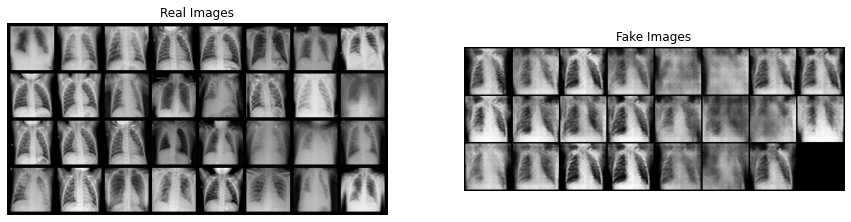

In [ ]:
test2(generator, discriminator, num_epochs, metrics, train_loader)

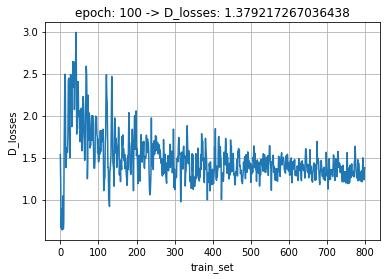

In [ ]:
save_model(generator, discriminator, optimizerG, optimizerD, metrics, num_epochs)

Discriminator s o/p tensor([[0.3659],
        [0.5745],
        [0.5172],
        [0.4262],
        [0.3118],
        [0.3229],
        [0.3278],
        [0.2713],
        [0.5597],
        [0.4213],
        [0.3655],
        [0.1485],
        [0.5273],
        [0.2364],
        [0.3784],
        [0.2657]], device='cuda:0', grad_fn=<SigmoidBackward>)
Discriminator c o/p tensor([[9.9995e-01, 7.4573e-06, 4.4422e-05],
        [9.9946e-01, 3.7034e-05, 4.9935e-04],
        [1.2589e-04, 2.6322e-03, 9.9724e-01],
        [9.9725e-01, 6.2166e-05, 2.6858e-03],
        [1.3435e-01, 8.5405e-01, 1.1603e-02],
        [9.6320e-04, 9.9903e-01, 4.9221e-06],
        [3.8539e-04, 5.1185e-04, 9.9910e-01],
        [1.5780e-03, 7.0178e-01, 2.9665e-01],
        [5.8448e-06, 9.9944e-01, 5.5230e-04],
        [9.2498e-02, 9.0462e-01, 2.8839e-03],
        [6.3354e-01, 5.0523e-04, 3.6596e-01],
        [5.2748e-03, 1.5330e-02, 9.7939e-01],
        [1.3467e-05, 2.0089e-03, 9.9798e-01],
        [2.2483e-04, 9.9977e-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


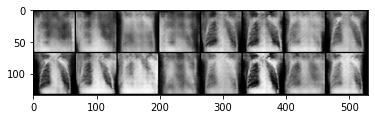

In [ ]:
test_batch = 16
test_fake = 1

if test_fake:
  #check for fake image
  test_img_list = []
  test_noise = torch.randn(test_batch, nz, 1, 1, device=device)
  test_img = generator(test_noise)#.detach().cpu()

else:
  #check for real image
  test_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch,
                                            shuffle=True)
  data = next(iter(test_loader))
  test_noise, test_class_lable = data
  test_img.data.resize_(test_noise.size()).copy_(test_noise)
  #print(data[0].size())
  print('class label for real', test_class_lable)

s_output,c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s o/p', s_output)
print('Discriminator c o/p', c_label_op)

# label = np.random.randint(0, nb_label, batch_size)
# c_label.data.resize_(batch_size).copy_(torch.from_numpy(label))
# print(c_label)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))